In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl

%run ../../scripts/mfss_model_train.py
%run ../../scripts/coherence_analysis_and_transform.py
%run ../../scripts/utils/data_processing.py
%run ../../scripts/figure_plots.py
%run ../../scripts/genes_from_cgs.py
%matplotlib inline

# Load in training and test data

In [2]:
data_path = '../../data/processed/'

In [3]:
# Read in the Hannum dataset for training
hannum = pd.read_pickle(data_path + 'GSE40279_hannum/hannum32.pkl')
hannum_meta = pd.read_excel(data_path + 'GSE40279_hannum/hannum_pmeta.xlsx')

In [4]:
# Read in the Lehne datasat for testing
lehne = np.load(data_path + 'GSE55763_lehne/lehne32_reduced.npy')
lehne_meta = pd.read_excel(data_path + 'GSE55763_lehne/lehne_pmeta.xlsx')
lehne_cgs = list_reader(data_path + 'GSE55763_lehne/cgs')
lehne = pd.DataFrame(lehne, columns=lehne_cgs)

In [5]:
art = np.load(data_path + 'GSE42861_arthritis/arthritis32_full.npy', allow_pickle=True)
art_meta = pd.read_excel(data_path + 'GSE42861_arthritis/arthritis_pmeta.xlsx')
cgs=list_reader(data_path + 'GSE42861_arthritis/cgs_full.txt')
art = pd.DataFrame(art, columns=cgs)

### Read in the filtered (less SNPs and CpGs missing from GSE55763) age correlations 'filtered_age_corrs.xlsx' stored in 'cpg_sets' directory

In [6]:
age_corrs=pd.read_excel(data_path + 'cpg_sets/filtered_age_corrs.xlsx')

In [7]:
#Identify arthritis-shifted CpGs
up_shift, down_shift = get_shifts(art, art_meta, age_corrs.CpG[:10000], 'Control')

#Combine
d_shift = pd.concat([up_shift,down_shift])
d_shift.reset_index(inplace=True, drop=True)
d_shift.sort_values(by='Order', ignore_index=True, inplace=True,ascending=True)

### Note: 'Correlation' in d_shift refers to the age correlation of the CpG within the dataset passed into get_shifts (e.g. arthritis), while 'Order' refers to the rank of the CpG within the CpG list passed into get_shifts (e.g. 'filtered_age_corrs', which is ranked by age correlation in the GSE40279 dataset)

# Generate Supplementary Table 3

In [8]:
#Get correlation magnitudes, sort correlation magnitude (descending)
d_shift['Abs. correlation'] = abs(d_shift.Correlation)
d_shift['Abs. d'] = abs(d_shift['Cohens d'])
d_shift

CpG     Shift  Correlation  Cohens d  Sign  Order  \
0     cg16867657 -0.009140     0.847155  0.663105    -1      0   
1     cg06639320 -0.007488     0.720896  0.569131    -1      1   
2     cg24724428 -0.014181     0.658811  0.895964    -1      2   
3     cg22454769  0.009697     0.730099 -0.629524     1      3   
4     cg24079702  0.006215     0.605845 -0.412700     1      4   
...          ...       ...          ...       ...   ...    ...   
9995  cg03085932  0.001308    -0.022486 -0.088130     1   9995   
9996  cg20786246 -0.004547     0.091143  0.452967    -1   9996   
9997  cg21463605 -0.013455    -0.059341  0.724346    -1   9997   
9998  cg14180030 -0.018956    -0.097448  1.669450    -1   9998   
9999  cg03587843 -0.018089     0.048034  1.458761    -1   9999   

      Abs. correlation    Abs. d  
0             0.847155  0.663105  
1             0.720896  0.569131  
2             0.658811  0.895964  
3             0.730099  0.629524  
4             0.605845  0.412700  
...                ...       ...  
9995          0.022486  0.088130  
9996          0.091143  0.452967  
9997          0.059341  0.724346  
9998          0.097448  1.669450  
9999          0.048034  1.458761  

[10000 rows x 8 columns]

In [9]:
# Reduce the datasets to only the top 10,000 age correlated CpGs
hannum=hannum[d_shift.CpG]
lehne=lehne[d_shift.CpG]
art=art[d_shift.CpG]

## Uncomment code below to simply load the art_corr_mfss_model, or skip and run subsequent cells to generate the model from the mFSS_OLS trainer

In [ ]:
# import joblib
# art_corr_mfss_model = joblib.load('../../models/art_corr_mfss_model.joblib')
# art_corr_mfss_selection = list(art_corr_mfss_model.feature_names_in_)

### Get the transformed data for the training (Hannum), validation (Lehne), and test (arthritis) sets

In [10]:
hannum_transform = coherence_transform(hannum, d_shift)
print('Done')
lehne_transform = coherence_transform(lehne, d_shift)
print('Done')
art_transform = coherence_transform(art, d_shift)

Done
Done


### Train an mFSS OLS model on RA-rectified features, with features added in based on their age correlation in the training set (GSE40279)

In [11]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, 
                                                                          hannum_meta,lehne_transform, lehne_meta,
                                                                          patience=800,rand_state=42,
                                                                          pos_weights=True)

# Generate Supplementary Figure 4a (top)

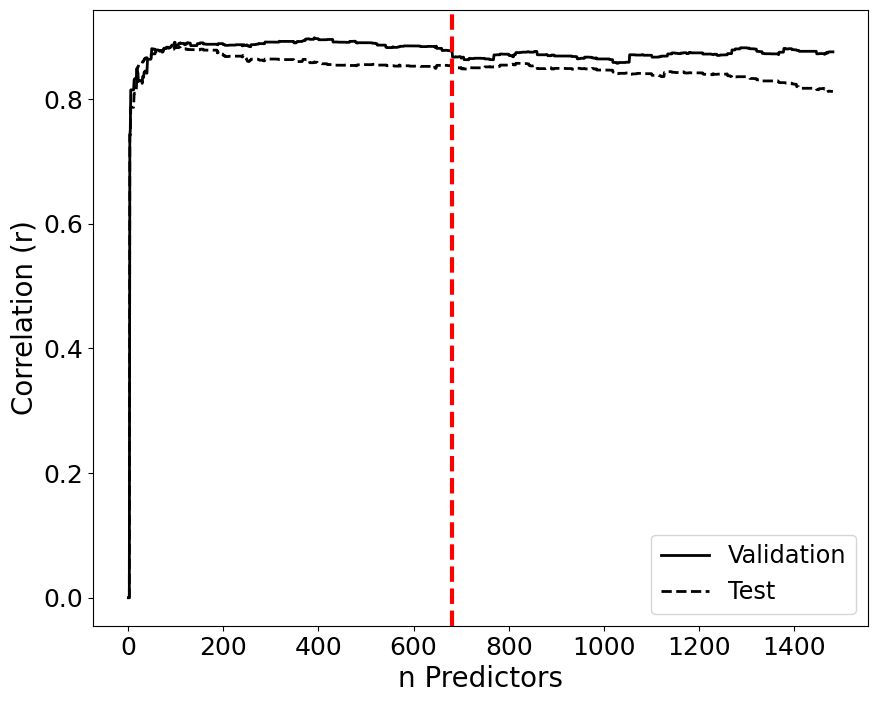

In [12]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

# Generate Supplementary Figure 4a (bottom)

In [13]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

In [14]:
best_iter

680

### Train the optimized model

In [15]:
art_corr_mfss_selection = age_corrs.CpG[:best_iter]
art_corr_mfss_model = LinearRegression(positive=True).fit(hannum_transform[art_corr_mfss_selection], hannum_meta.age)

# Generate Supplementary Table 4

In [393]:
model_df = pd.DataFrame({'Feature': art_corr_mfss_model.feature_names_in_, 'Weight': art_corr_mfss_model.coef_})
new_row = {'Feature': 'Intercept', 'Weight': art_corr_mfss_model.intercept_, 'Signal shift': 'NA', 'Reflect': 'NA'}
model_df = model_df[model_df.Weight!=0].reset_index(drop=True)
# sort the rows by CpG
model_df.sort_values('Feature', inplace=True, ignore_index=True)

# Create a filter for the rows in d_shift where CpG values are in model_df.Feature
filtered_d_shift = d_shift[d_shift.CpG.isin(model_df.Feature)].copy()
# sort the rows by CpG to match the row order of model_df
filtered_d_shift.sort_values('CpG', inplace=True, ignore_index=True)

model_df['Signal shift'] = filtered_d_shift.Shift.tolist()
model_df['Reflect'] = filtered_d_shift.Sign.tolist()
# Replace 1 with 'False' and -1 with 'True' indicating if the feature was reflected
model_df['Reflect'] = model_df['Reflect'].replace({1: False, -1: True})
# Add the new row
model_df.loc[len(model_df)] = new_row
model_df

Feature      Weight Signal shift Reflect
0    cg00103778   16.455812     0.001677   False
1    cg00210249   11.286157      0.00727   False
2    cg00308841    4.345771     0.001553   False
3    cg00327072    7.449950     0.000133   False
4    cg00387658   11.168719     0.005229   False
..          ...         ...          ...     ...
120  cg26210267   10.808466     -0.00311    True
121  cg26424147   12.467615     0.004448   False
122  cg27068143    3.556774     0.000446   False
123  cg27346545    1.126347    -0.012131    True
124   Intercept -562.840820           NA      NA

[125 rows x 4 columns]

### Load in GSE72774 (Parkinson's disease) dataset

In [29]:
park = pd.read_pickle(data_path + 'GSE72774_parkinsons/parkinsons32.pkl')
park_meta = pd.read_excel(data_path + 'GSE72774_parkinsons/parkinsons_pmeta.xlsx')
park=park.reset_index(drop=True)
from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=2)
# Fit and transform the DataFrame with the imputer
imputed = imputer.fit_transform(park)
park = pd.DataFrame(imputed, columns=park.columns)

# Generate Supplementary Figure 4b

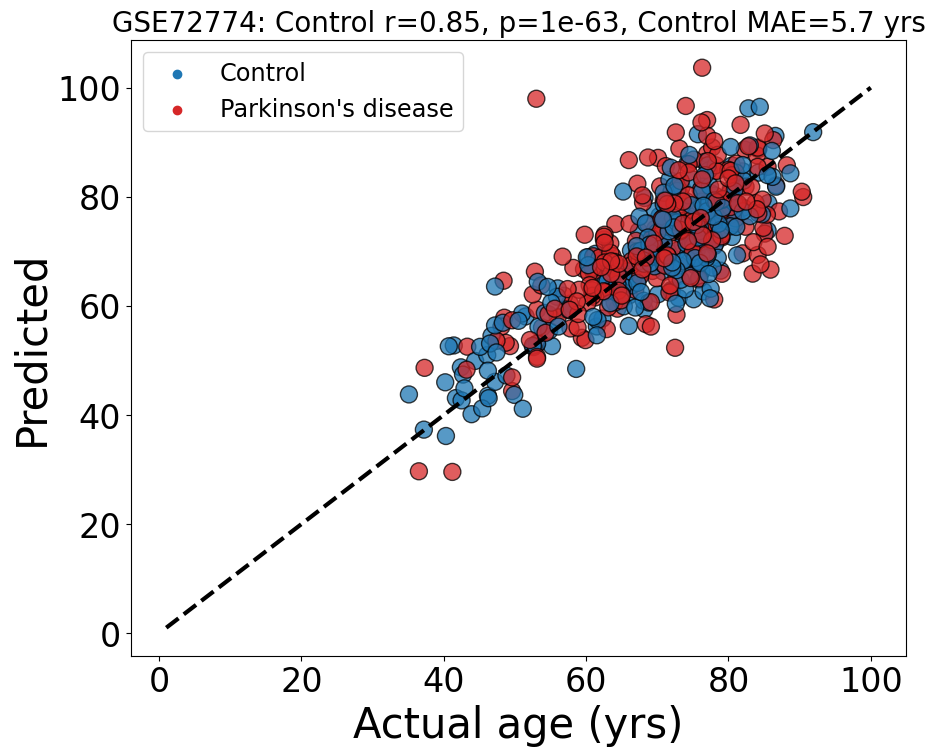

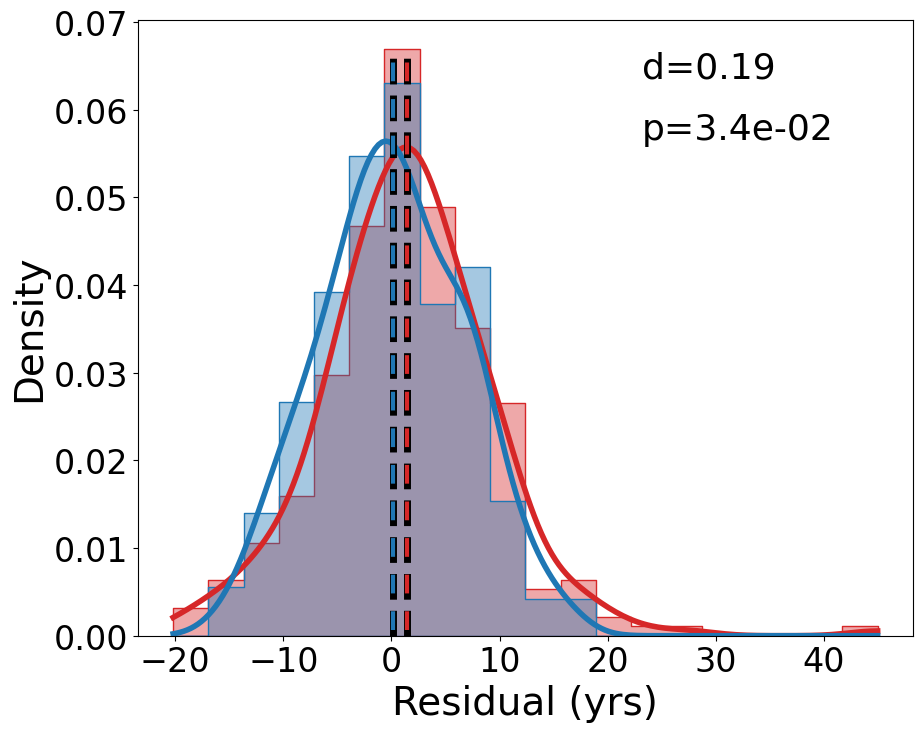

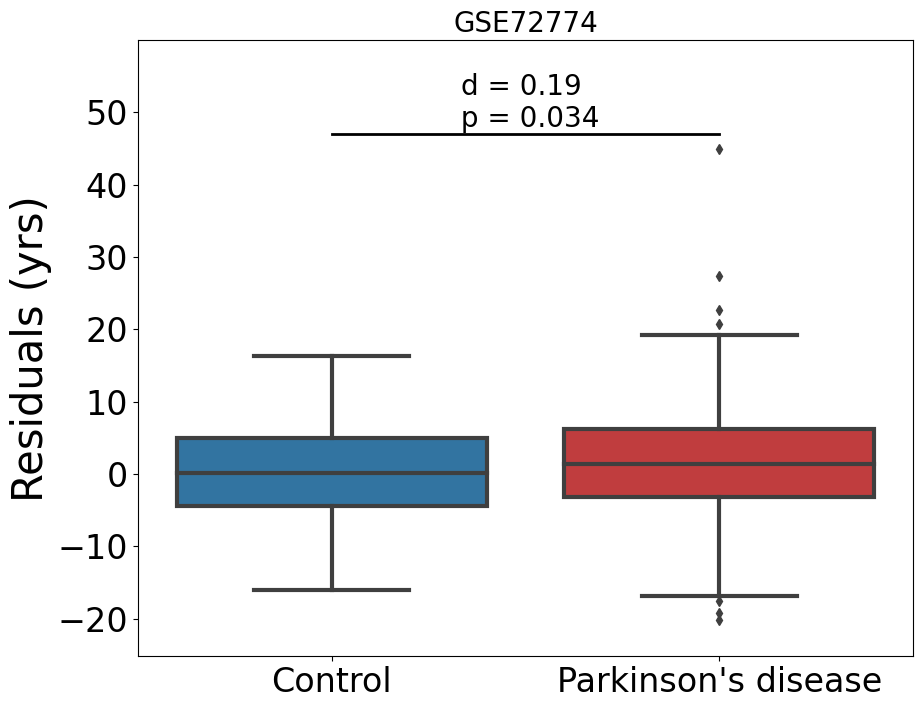

In [349]:
fig4_plots(park, park_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"Parkinson's disease", flag=False)

### Load in GSE125105 (Depression) dataset

In [32]:
dep = np.load(data_path + 'GSE125105_depression/depression32_full.npy', allow_pickle=True)
dep_meta = pd.read_excel(data_path + 'GSE125105_depression/depression_pmeta.xlsx')
cg_list = list_reader(data_path + 'GSE125105_depression/depression_cgs_full.txt')
dep = pd.DataFrame(dep, columns=cg_list)

# Generate Supplementary Figure 4c

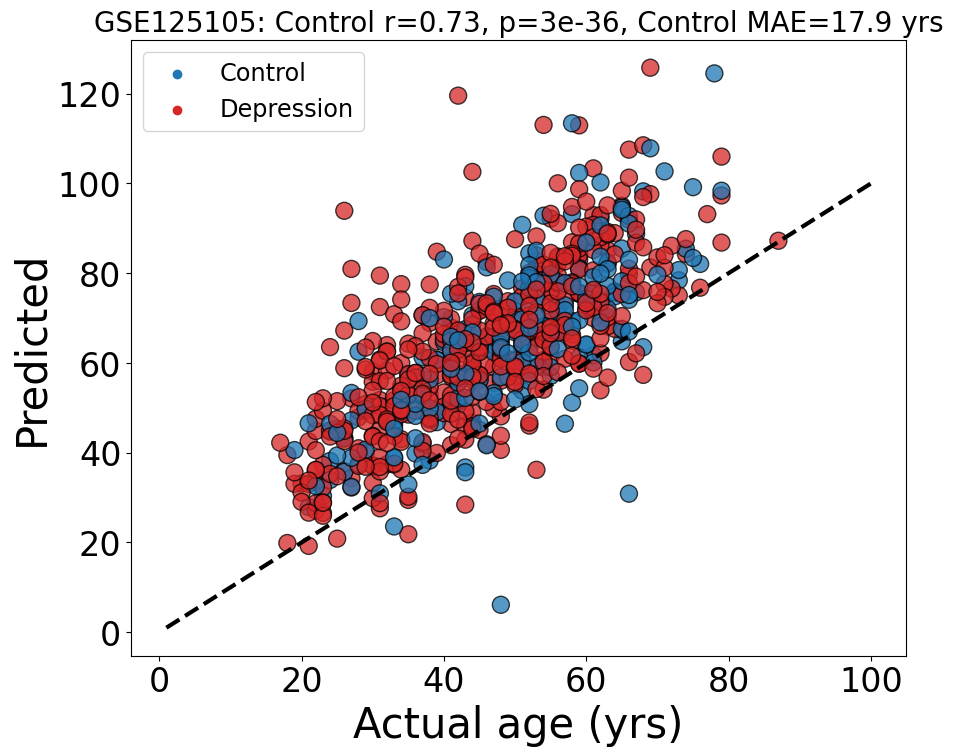

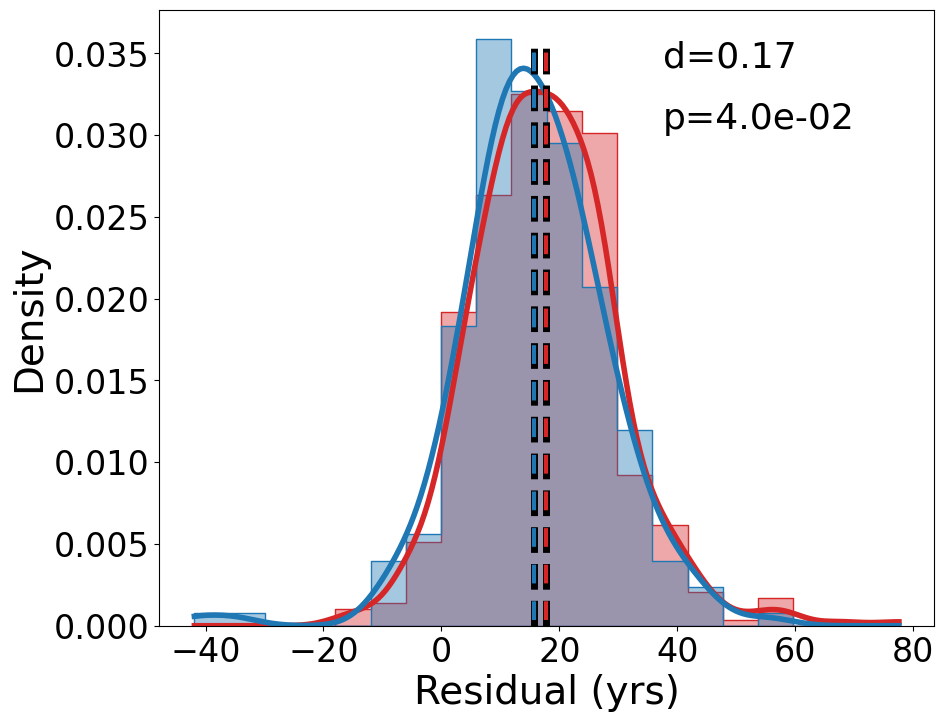

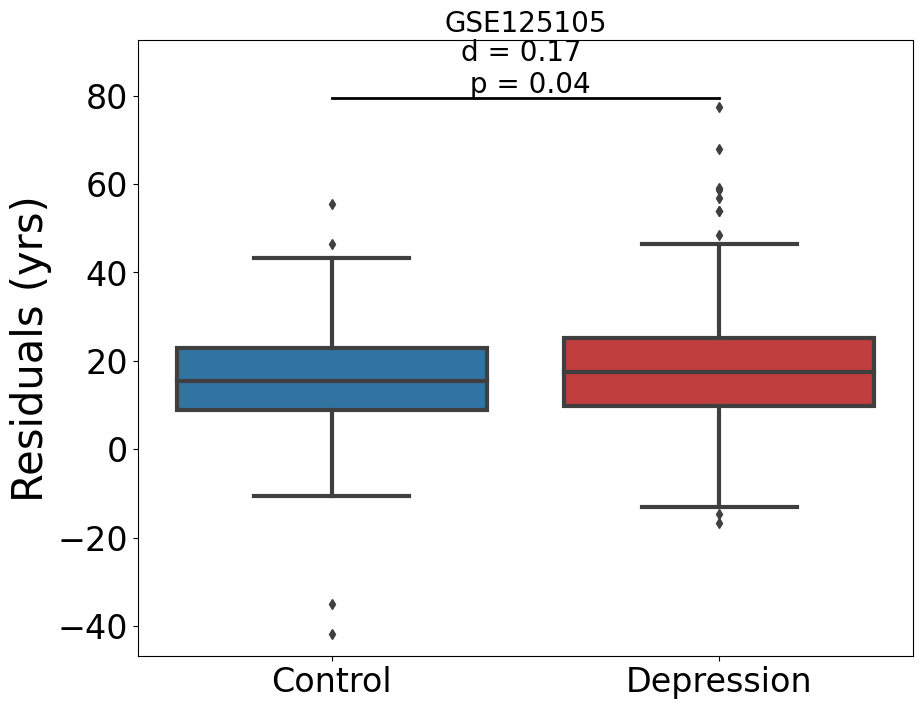

In [350]:
fig4_plots(dep, dep_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"Depression", flag=False)

### Load in GSE106648 (MS) dataset

In [35]:
ms = pd.read_pickle(data_path + 'GSE106648_ms/MS32.pkl')
ms_meta = pd.read_excel(data_path + 'GSE106648_ms/MS_pmeta.xlsx')
from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=2)
# Fit and transform the DataFrame with the imputer
imputed = imputer.fit_transform(ms)
ms = pd.DataFrame(imputed, columns=ms.columns)

# Generate Supplementary Figure 4d

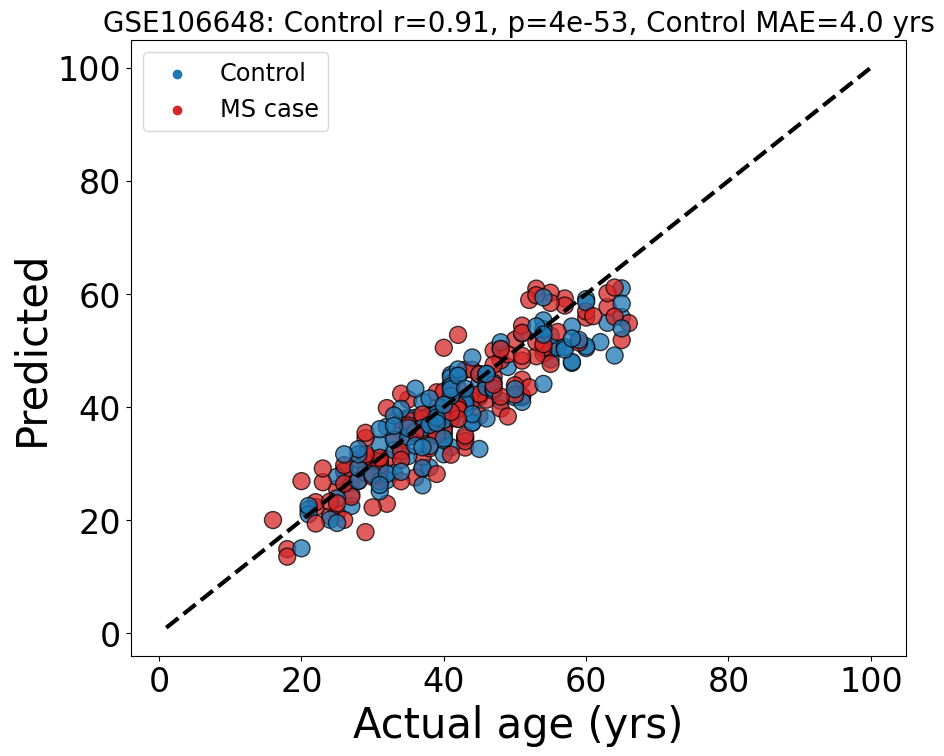

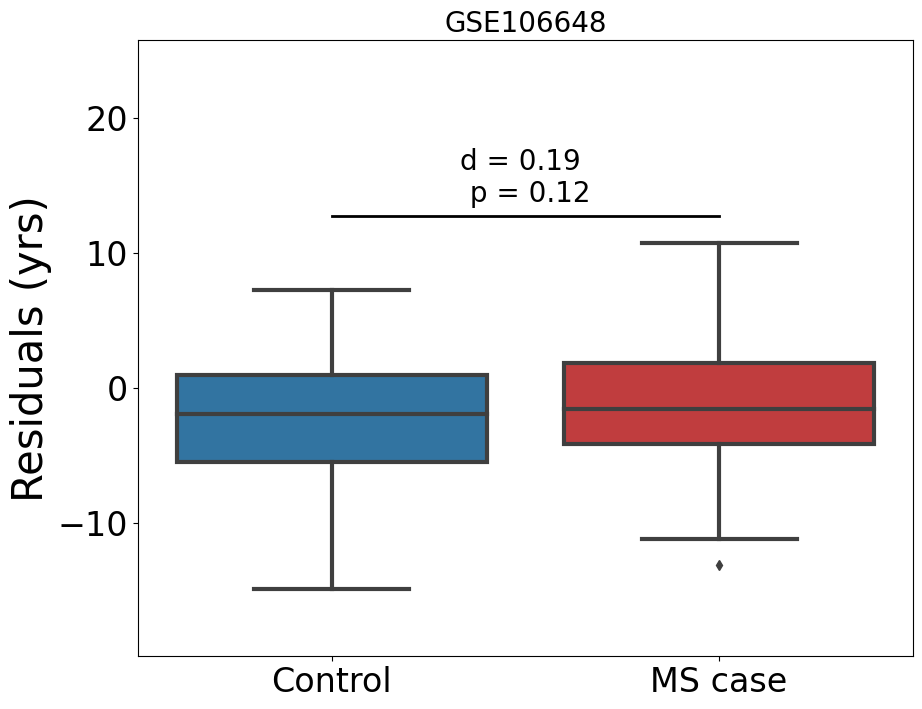

In [351]:
fig4_plots(ms, ms_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"MS case", flag=False)

### Load in GSE53740 (Tauopathy) dataset

In [37]:
tau = np.load(data_path + 'GSE53740_tauopathy/tauopathy32.npy', allow_pickle=True)
tau_meta = pd.read_excel(data_path + 'GSE53740_tauopathy/tauopathy_pmeta.xlsx')
cg_list = list_reader(data_path + 'GSE53740_tauopathy/cgs.txt')
tau = pd.DataFrame(tau, columns=cg_list)

# Generate Supplementary Figure 4e

In [353]:
fig4_plots(tau, tau_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"Tauopathy", flag=True)

## Uncomment code below to simply load the art_shift_mfss_model, or skip and run subsequent cells to generate the model from the mFSS_OLS trainer

In [ ]:
# import joblib
# art_shift_mfss_model = joblib.load('../../models/art_shift_mfss_model.joblib')
# art_shift_mfss_selection = list(art_shift_mfss_model.feature_names_in_)

## Train Arthritis-rectified mFSS based on disease shift magnitude

In [25]:
#Re-sort by disease shift magnitude
d_shift['Abs. shift'] = abs(d_shift.Shift)
d_shift.sort_values(by="Abs. shift", inplace=True,ignore_index=True,ascending=False)

In [26]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, hannum_meta,
                                                                             lehne_transform, lehne_meta,800, pos_weights=True)

# Generate Supplementary Figure 5a (top)

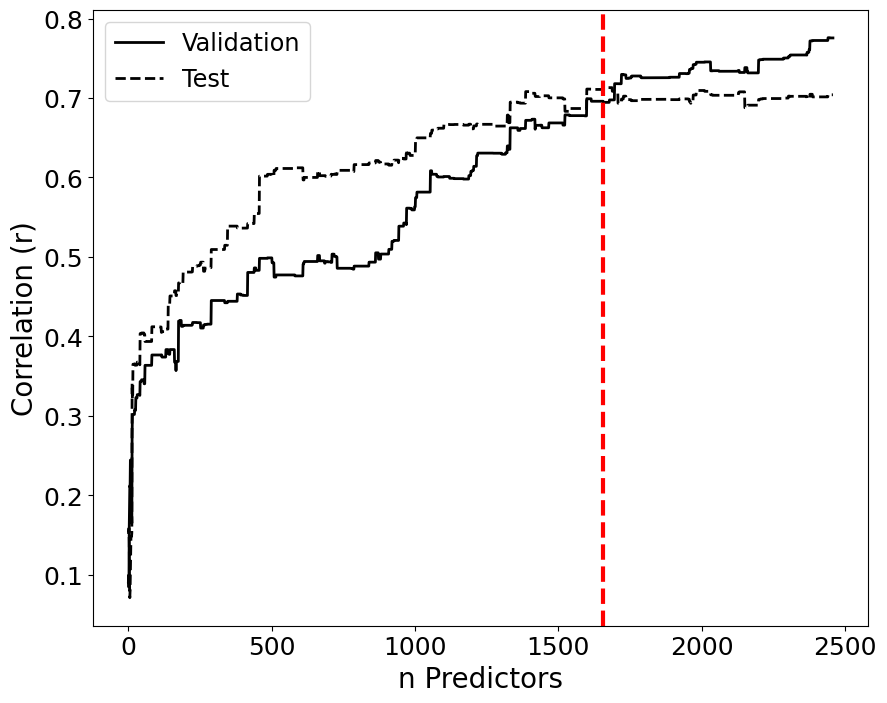

In [27]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

# Generate Supplementary Figure 5a (bottom)

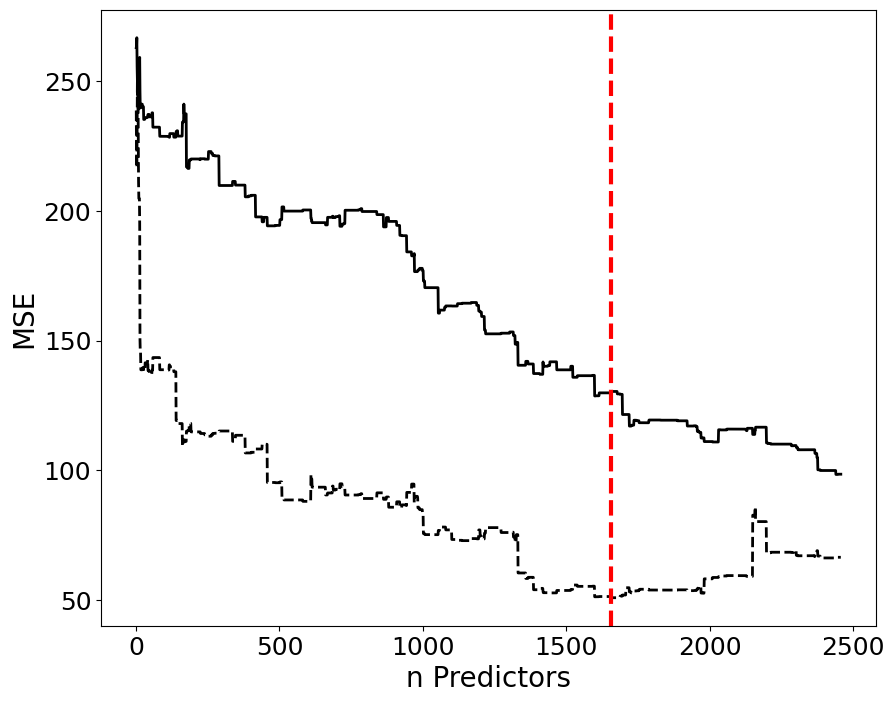

In [28]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

In [29]:
best_iter

1656

### Train the optimized model

In [30]:
art_shift_mfss_selection = d_shift.CpG[:best_iter]
art_shift_mfss_model = LinearRegression(positive=True).fit(hannum_transform[art_shift_mfss_selection], hannum_meta.age)

# Generate Supplementary Figure 5b (plus KDE plot)

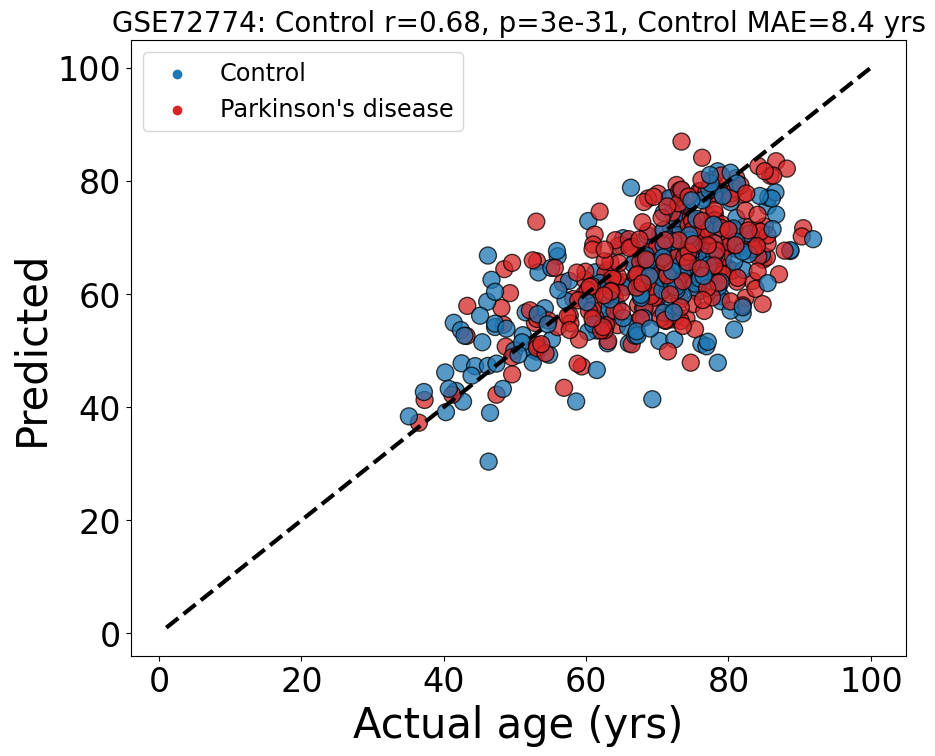

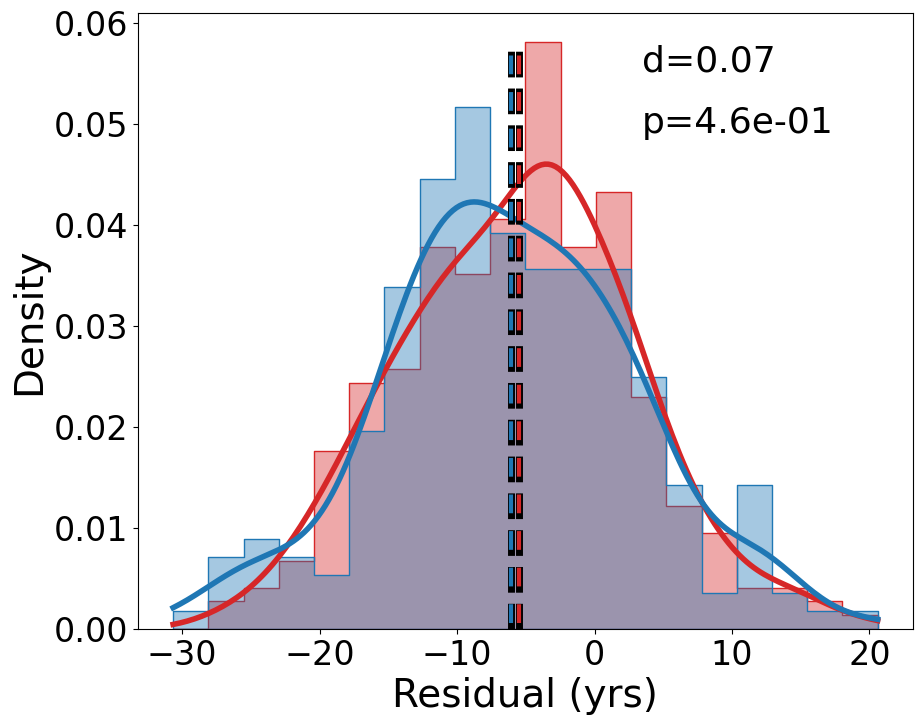

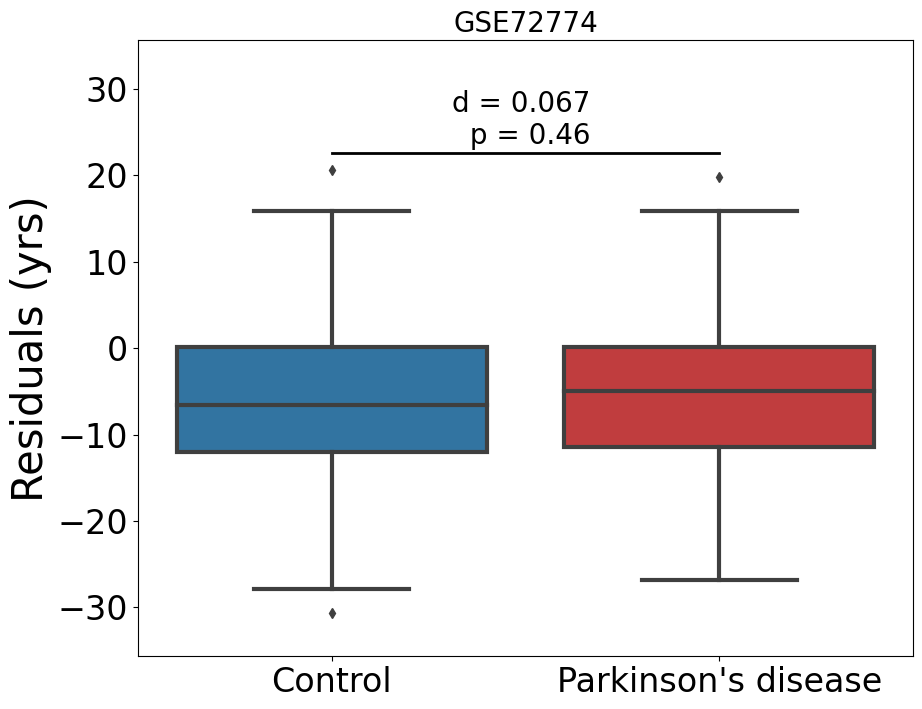

In [370]:
fig4_plots(park, park_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Parkinson's disease", flag=False)

# Generate Supplementary Figure 5c (plus KDE plot)

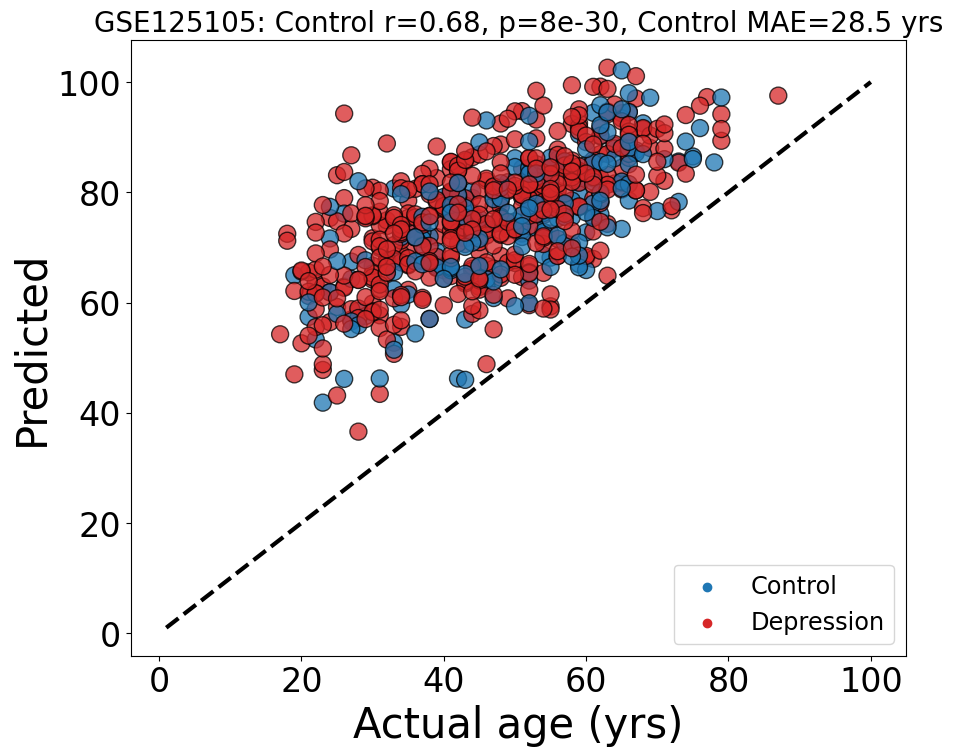

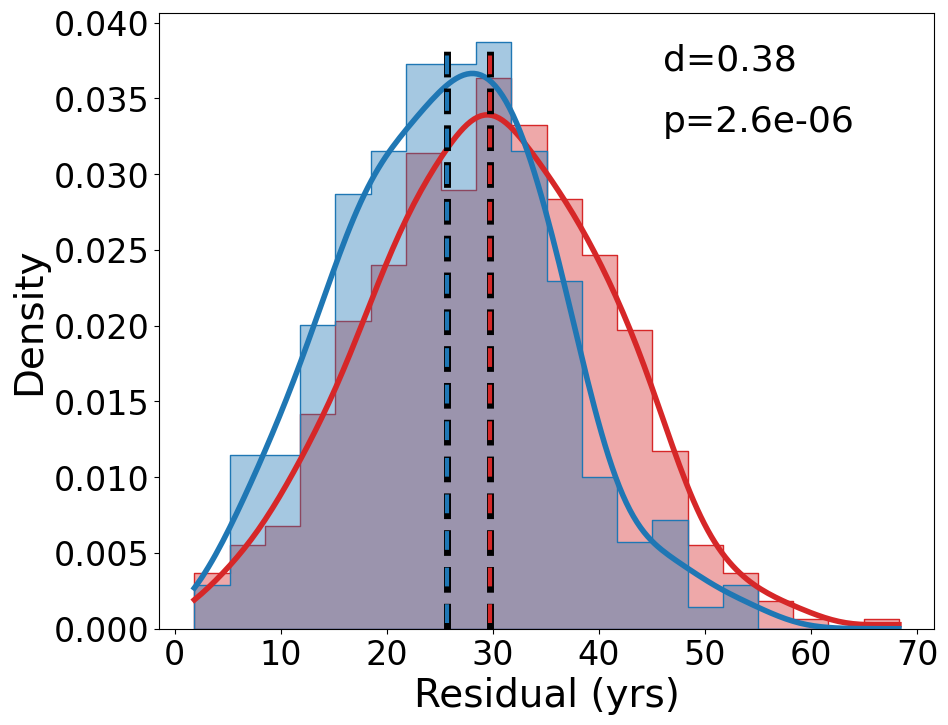

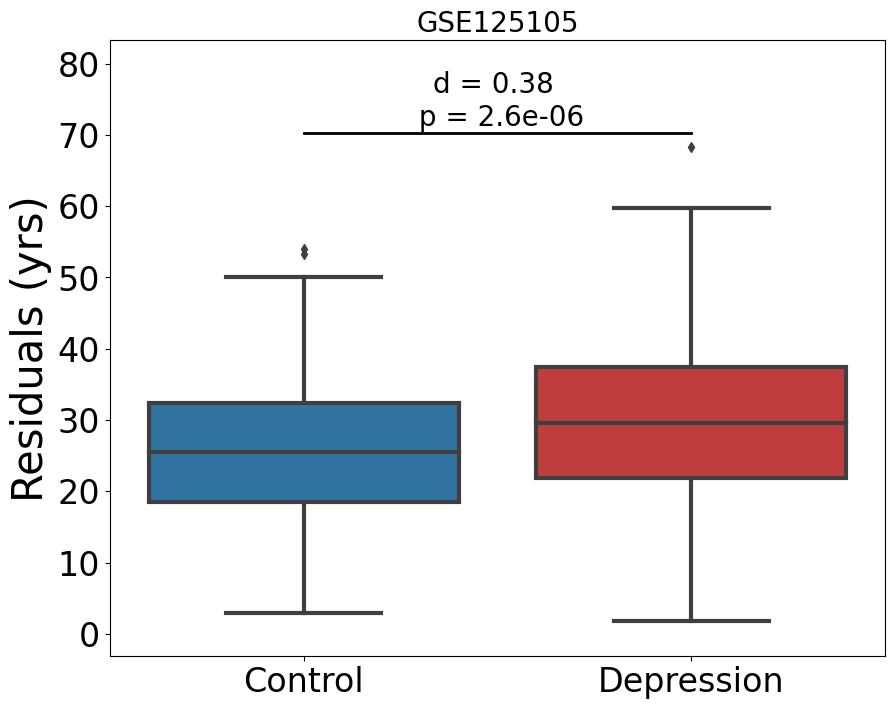

In [371]:
fig4_plots(dep, dep_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Depression", flag=False)

# Generate Supplementary Figure 5d (plus KDE plot)

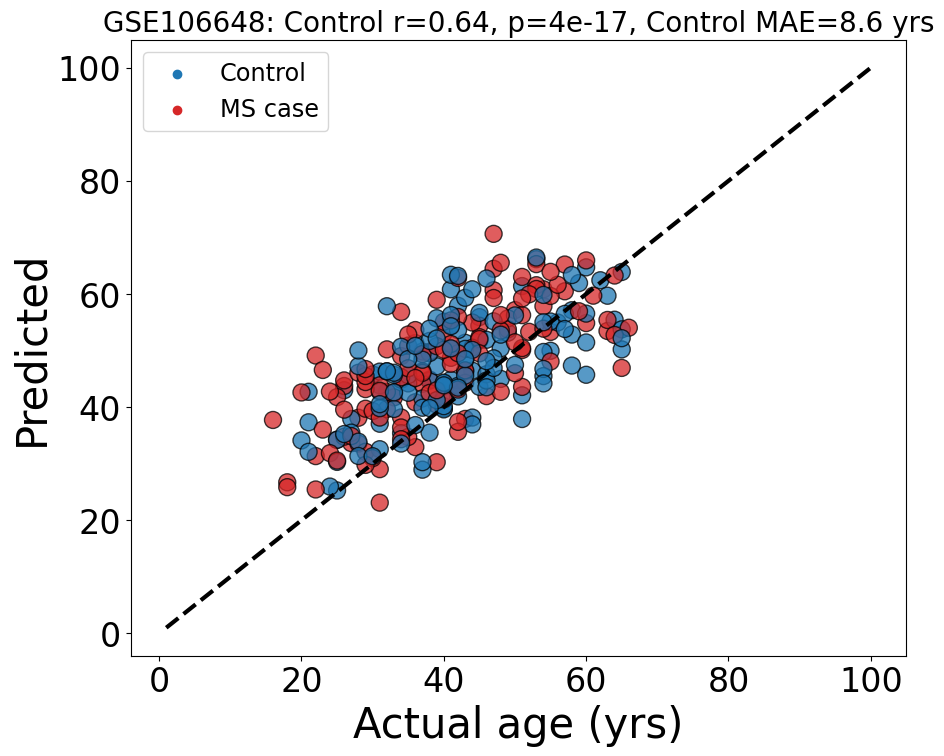

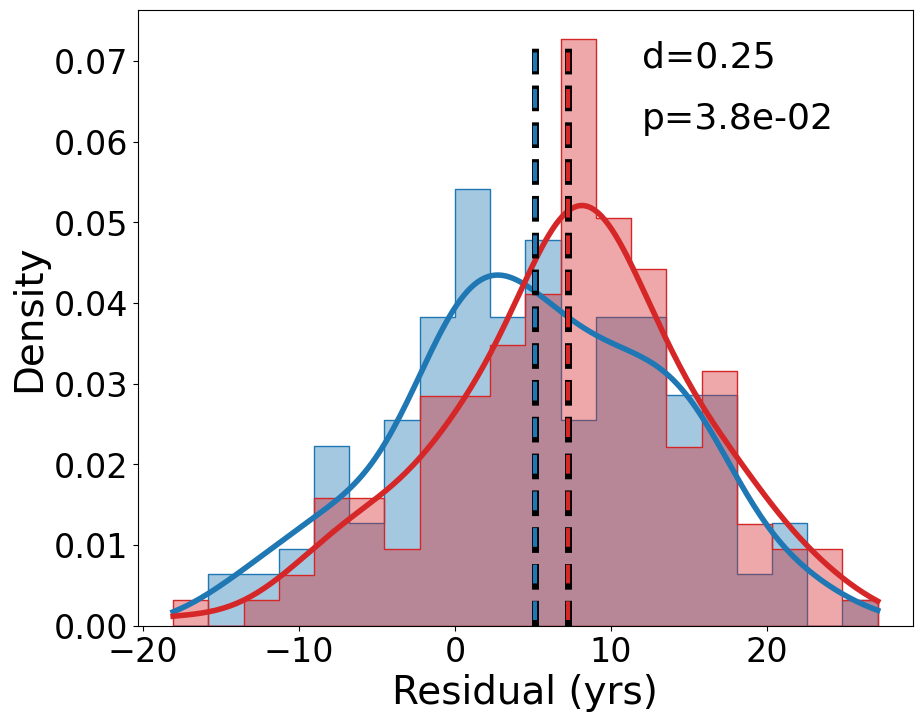

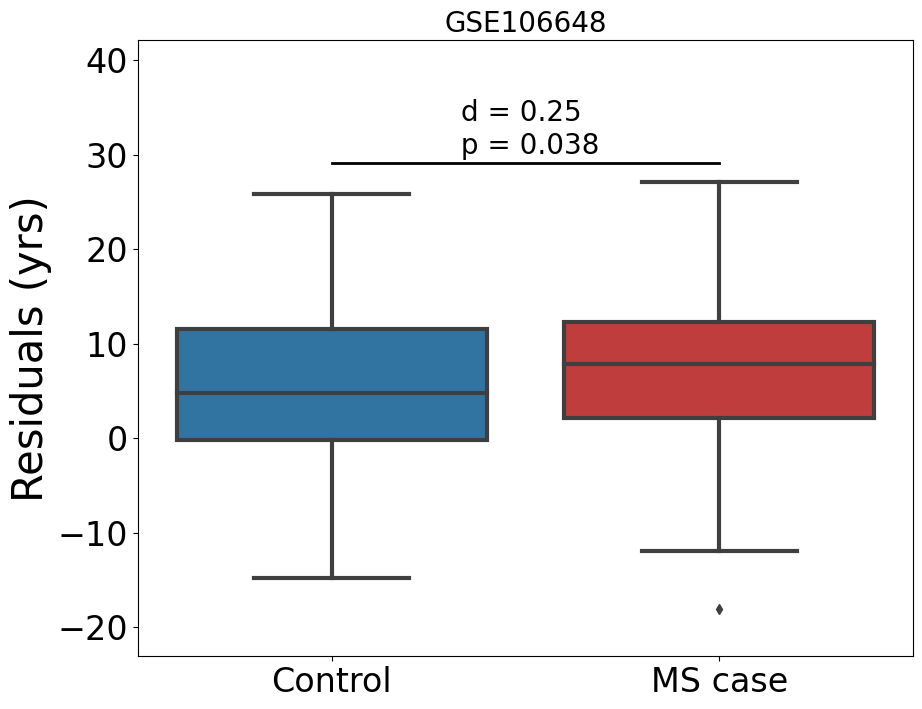

In [372]:
fig4_plots(ms, ms_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"MS case", flag=False)

# Generate Supplementary Figure 5e (plus KDE plot)

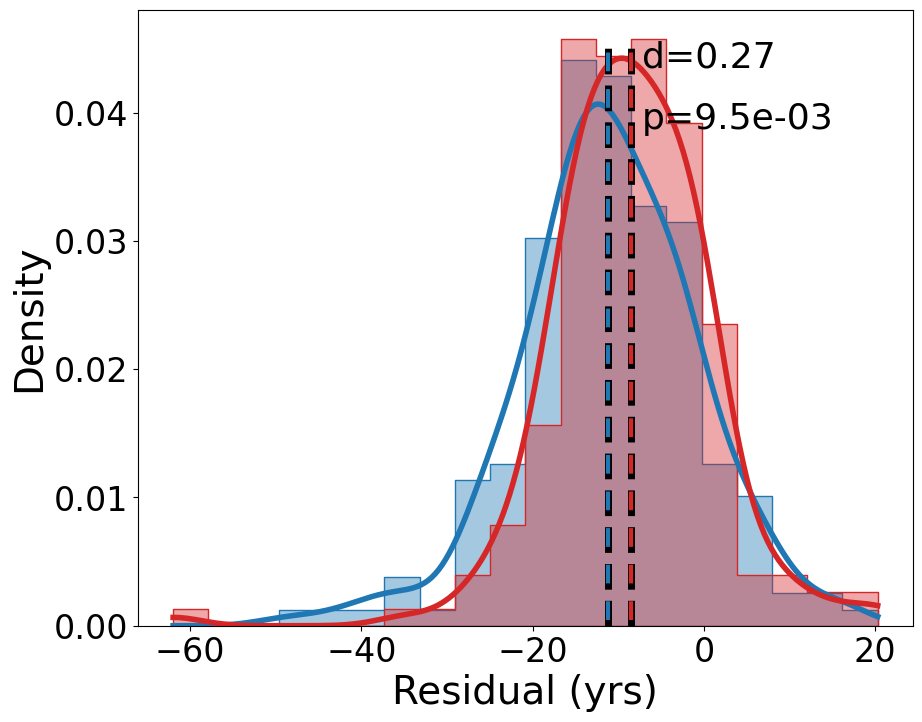

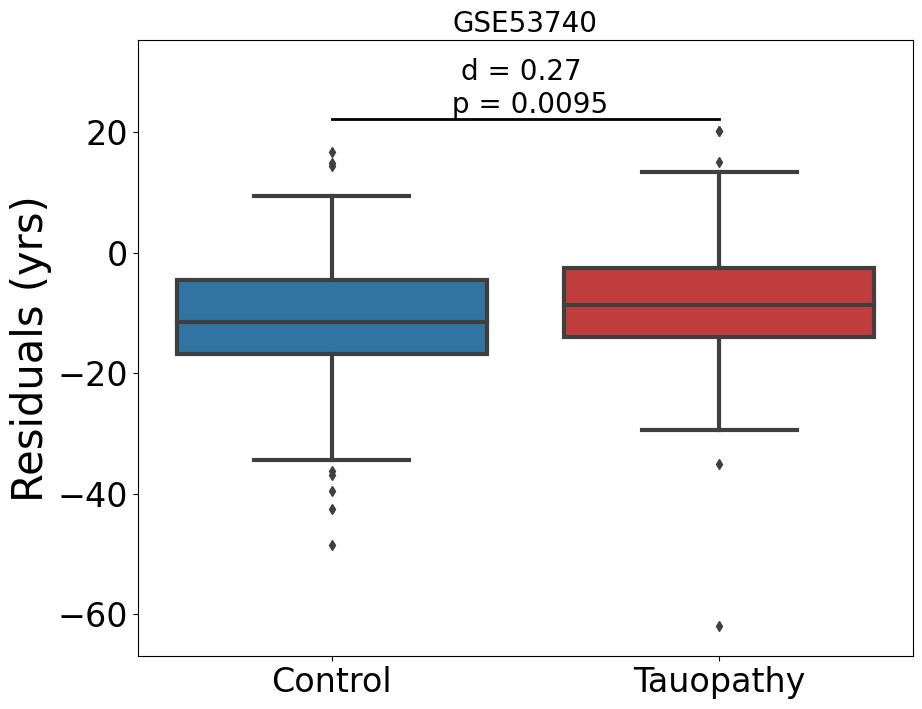

In [373]:
fig4_plots(tau, tau_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Tauopathy", flag=True)

# Generate Supplementary Figure 5f (plus KDE plot)

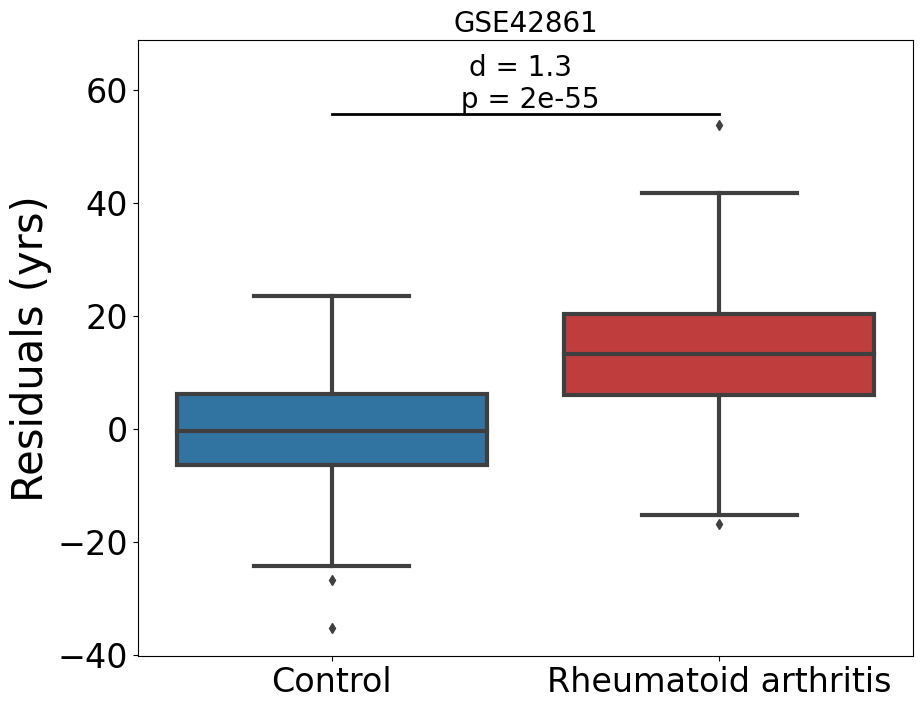

In [374]:
fig4_plots(art, art_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Rheumatoid arthritis", flag=False)

## Load and prep the V7 dataset

In [22]:
h_comb = np.load(data_path + 'combined_v7/V7_healthy.npy', allow_pickle=True)
d_comb = np.load(data_path + 'combined_v7/V7_disease.npy', allow_pickle=True)
cgs=list_reader(data_path + 'combined_v7/V7_cgs.txt')
h_comb = pd.DataFrame(h_comb, columns=cgs)
d_comb = pd.DataFrame(d_comb, columns=cgs)

v7_meta = pd.read_excel(data_path + 'combined_v7/V7_pmeta.xlsx')
h_meta = v7_meta.copy()
d_meta = v7_meta.copy()
h_meta = h_meta[h_meta.disease==0]
d_meta = d_meta[d_meta.disease==1]
h_meta.reset_index(drop=True, inplace=True)
d_meta.reset_index(drop=True, inplace=True)

#combine into one dataset
v7 = pd.concat([h_comb,d_comb],ignore_index=True)
v7_meta = pd.concat([h_meta,d_meta],ignore_index=True)

### Remove the Depression samples from the v7 training dataset and v7 metadata; Depression will be used as a test set

In [23]:
no_dep = v7[v7_meta.series_id!="GSE125105"]
no_dep_meta =v7_meta[v7_meta.series_id!="GSE125105"]

# Ensure no_dep_meta is an independent copy
no_dep_meta = no_dep_meta.copy()

# Create new labels
new_labels = ["Control" if value == 0 else "Inflammaging" for value in no_dep_meta.disease]

# Safely redefine the column
no_dep_meta['disease_state'] = new_labels

In [17]:
up_shift, down_shift = get_shifts(no_dep, no_dep_meta, age_corrs.CpG[:10000], 'Control')
#Combine
d_shift = pd.concat([up_shift,down_shift])
d_shift.reset_index(inplace=True, drop=True)

# #Re-sort by disease shift magnitude
d_shift['Abs. shift'] = abs(d_shift.Shift)
d_shift.sort_values(by="Abs. shift", inplace=True,ignore_index=True,ascending=False)

# Generate Supplementary Table 5

In [19]:
d_shift

CpG         Shift  Correlation  Cohens d  Sign  Order  \
0     cg08450017  8.271058e-02     0.221020 -5.233291     1   7144   
1     cg09290120 -7.425385e-02    -0.025896  4.754762    -1   8972   
2     cg02345886 -6.767714e-02     0.084284  4.448234    -1   8071   
3     cg03607951 -6.714863e-02     0.031040  4.287630    -1   7109   
4     cg22217449  6.613557e-02     0.353864 -4.656456     1   9307   
...          ...           ...          ...       ...   ...    ...   
9995  cg14163776 -5.991465e-06     0.098574  0.000556    -1   4589   
9996  cg11741201 -4.361600e-06    -0.178769  0.000384    -1     72   
9997  cg26301489  1.229438e-06    -0.045249 -0.000117     1   5142   
9998  cg07171111 -9.340503e-07     0.258625  0.000132    -1   1039   
9999  cg26627568  4.239293e-07     0.128330 -0.000065     1   8591   

        Abs. shift  
0     8.271058e-02  
1     7.425385e-02  
2     6.767714e-02  
3     6.714863e-02  
4     6.613557e-02  
...            ...  
9995  5.991465e-06  
9996  4.361600e-06  
9997  1.229438e-06  
9998  9.340503e-07  
9999  4.239293e-07  

[10000 rows x 7 columns]

## Uncomment code below to simply load the IR-mFSS model, or skip and run subsequent cells to generate the model from the mFSS_OLS trainer

In [ ]:
# import joblib
# ir_shift_mfss_model = joblib.load('../../models/ir-mfss_model.joblib')
# ir_shift_mfss_selection = list(ir_shift_mfss_model.feature_names_in_)

In [18]:
#get the transformed data for the training (Hannum), validation (Lehne), and test (v7) sets

hannum_transform = coherence_transform(hannum, d_shift)
print("Done")
lehne_transform = coherence_transform(lehne, d_shift)
print("Done")
no_dep_transform = coherence_transform(no_dep, d_shift)

Done
Done


In [21]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, hannum_meta,
                                                                             lehne_transform, lehne_meta, 1800,pos_weights=True)

# Generate Supplementary Figure 6a (top)

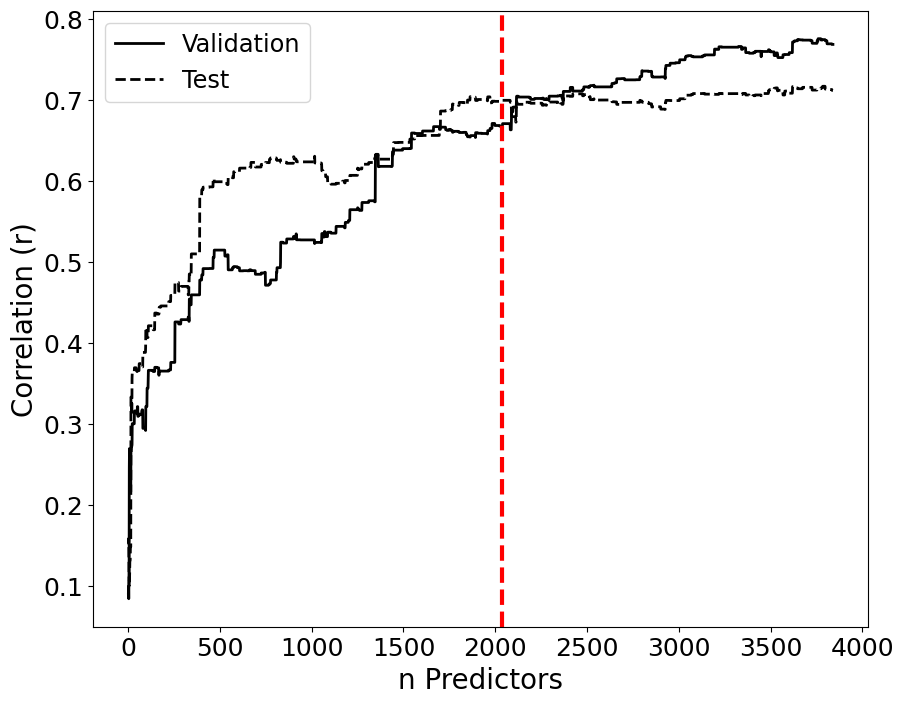

In [22]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

# Generate Supplementary Figure 6a (bottom)

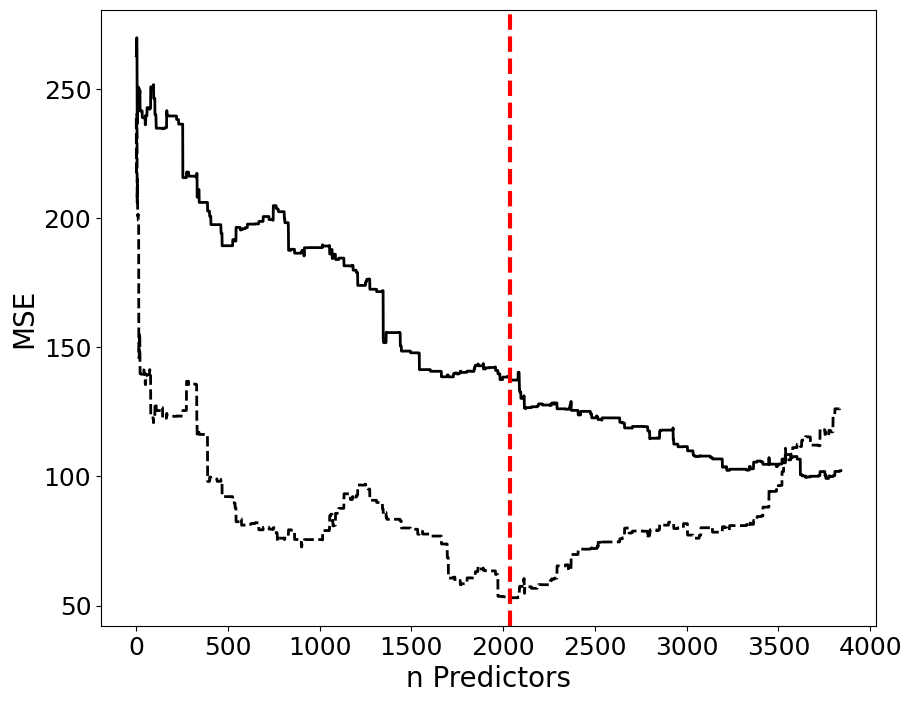

In [23]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

In [24]:
best_iter

2039

In [26]:
ir_shift_mfss_selection = d_shift.CpG[:best_iter]
ir_shift_mfss_model = LinearRegression(positive=True).fit(hannum_transform[ir_shift_mfss_selection], hannum_meta.age)

# Generate Supplementary Table 6

In [27]:
model_df = pd.DataFrame({'Feature': ir_shift_mfss_model.feature_names_in_, 'Weight': ir_shift_mfss_model.coef_})
new_row = {'Feature': 'Intercept', 'Weight': ir_shift_mfss_model.intercept_, 'Signal shift': 'NA', 'Reflect': 'NA'}
model_df = model_df[model_df.Weight!=0].reset_index(drop=True)
# sort the rows by CpG
model_df.sort_values('Feature', inplace=True, ignore_index=True)

# Create a filter for the rows in d_shift where CpG values are in model_df.Feature
filtered_d_shift = d_shift[d_shift.CpG.isin(model_df.Feature)].copy()
# sort the rows by CpG to match the row order of model_df
filtered_d_shift.sort_values('CpG', inplace=True, ignore_index=True)

model_df['Signal shift'] = filtered_d_shift.Shift.tolist()
model_df['Reflect'] = filtered_d_shift.Sign.tolist()
# Replace 1 with 'False' and -1 with 'True' indicating if the feature was reflected
model_df['Reflect'] = model_df['Reflect'].replace({1: False, -1: True})
# Add the new row
model_df.loc[len(model_df)] = new_row
model_df

Feature      Weight Signal shift Reflect
0        cg00161515   41.177921     0.014071   False
1        cg00573770    3.256834    -0.029635    True
2        cg01101873    5.186465    -0.015181    True
3        cg01459453    6.618000    -0.015261    True
4        cg01820962    2.849810    -0.019334    True
5        cg03335938    8.357692    -0.014717    True
6        cg03366574   16.972960     0.015745   False
7        cg03646329    3.497622     0.026464   False
8        cg04135377    0.564180    -0.018827    True
9        cg04986004    1.987299    -0.014925    True
10       cg04987734   11.611787     0.017146   False
11       cg05507459    1.802377    -0.014778    True
12       cg05696969   13.736624    -0.017189    True
13       cg05899984   11.412278     0.014595   False
14       cg06419846   25.681061     0.022221   False
15       cg06896988    5.955002    -0.019875    True
16       cg07192048    2.230313     0.015042   False
17       cg09124496    1.670846    -0.015096    True
18       cg09790134    6.304162    -0.018794    True
19       cg10144493   30.416718    -0.015478    True
20       cg10202113   11.232876     0.020416   False
21       cg11067179   38.856602      0.01981   False
22       cg11404203    9.066732     0.014918   False
23       cg11847992    9.888449    -0.018764    True
24       cg13001142    5.038072    -0.016571    True
25       cg14076258    2.851478    -0.016117    True
26       cg14614643    3.515961    -0.015061    True
27       cg15167547    1.732737     -0.01891    True
28       cg15853350   10.824588      0.01456   False
29       cg15903032    5.399612    -0.015776    True
30       cg16618104    9.089783    -0.018279    True
31       cg17621438    5.708115    -0.014359    True
32       cg17802213   11.955949     0.014133   False
33       cg19307545    3.327909     0.017734   False
34       cg19421125    6.307817    -0.014688    True
35       cg21139312   37.090309     0.014031   False
36       cg22914338    1.561304    -0.014723    True
37       cg23126342    5.322215    -0.028057    True
38       cg23167606    1.996659     0.016242   False
39       cg23227285   21.824327     0.016542   False
40       cg23395688   26.180193    -0.015562    True
41       cg23744638   25.525152    -0.017741    True
42       cg23922560   29.314737     0.014414   False
43       cg25607920    4.304700    -0.028401    True
44       cg26665035    6.175128    -0.018507    True
45       cg27598407    1.501359     0.017038   False
46  ch.7.143447326F    9.466154     0.013906   False
47        Intercept -245.954987           NA      NA

# Generate Figure 4a-c (left)

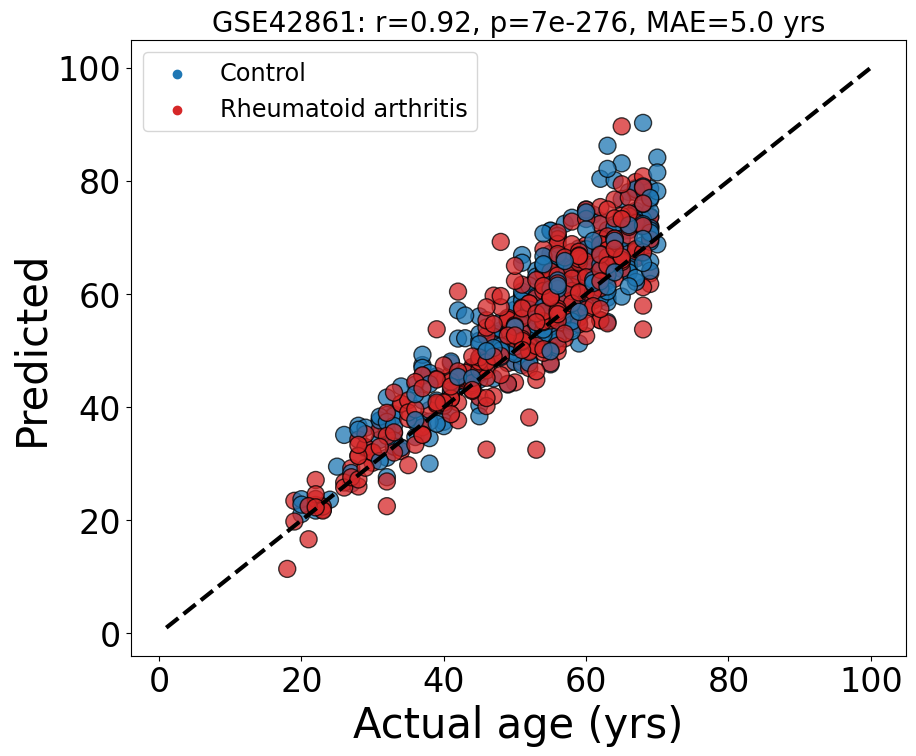

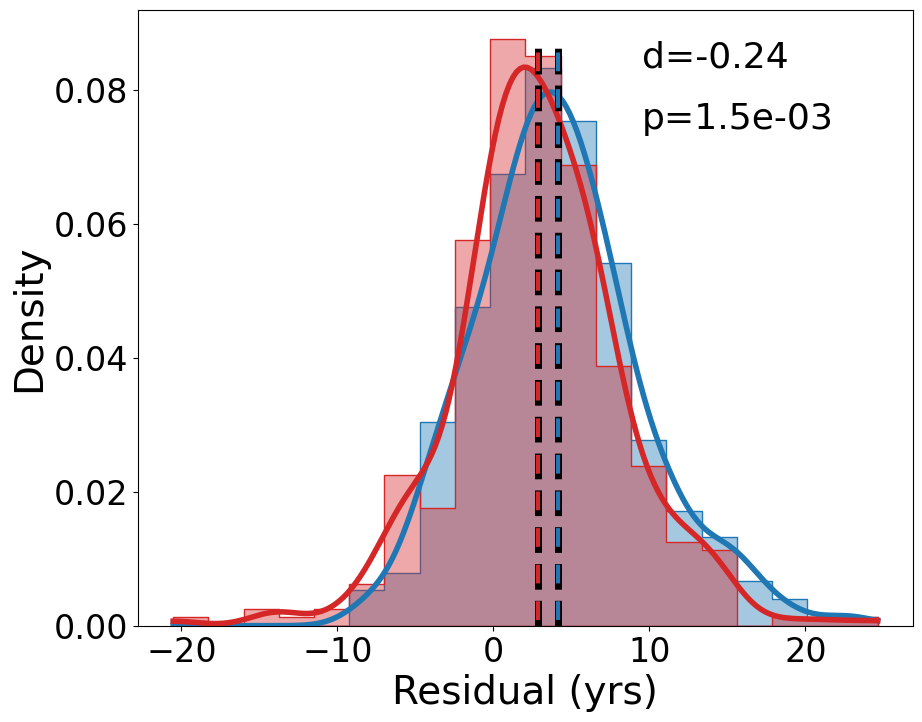

In [20]:
import joblib
age_corr_mfss_model = joblib.load('../../models/age_corr_mfss_model.joblib')
age_corr_mfss_selection = list(age_corr_mfss_model.feature_names_in_)
fig3_plots(art,art_meta,age_corr_mfss_model, age_corr_mfss_selection, "Rheumatoid arthritis", flag=False)

## Load the art_corr_mfss_model to generate Figure 4a-c (right)

In [17]:
import joblib
art_corr_mfss_model = joblib.load('../../models/art_corr_mfss_model.joblib')
art_corr_mfss_selection = list(art_corr_mfss_model.feature_names_in_)

# Generate Figure 4a-c (right)

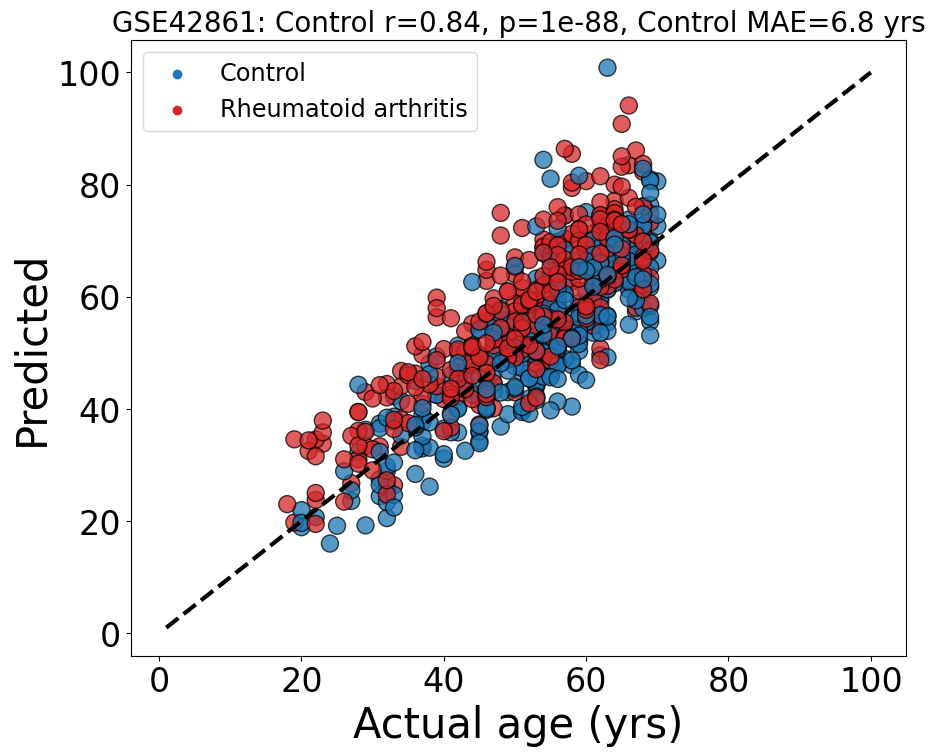

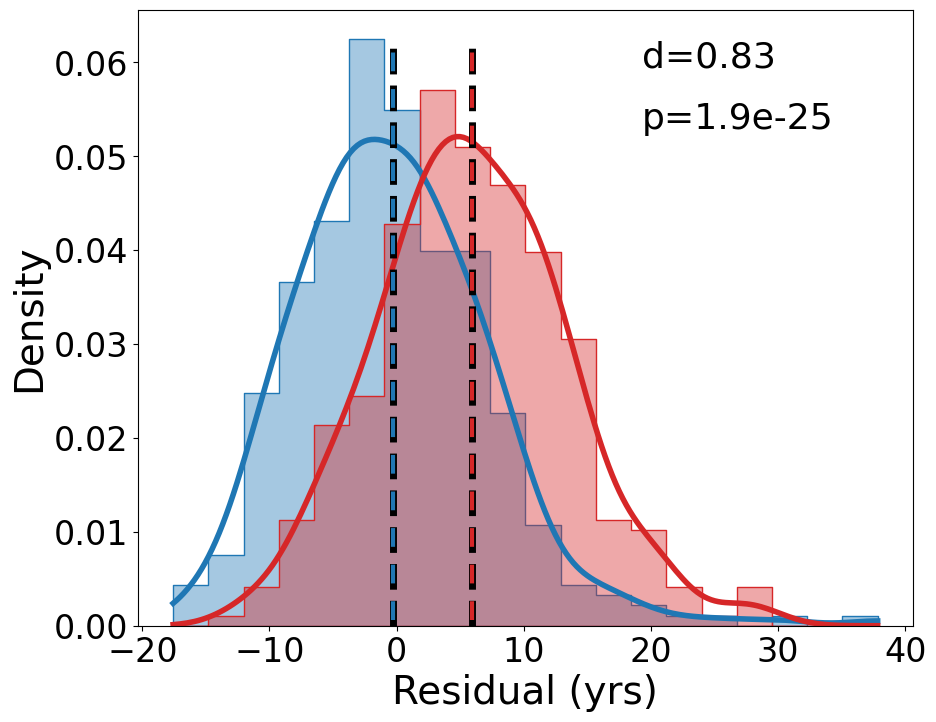

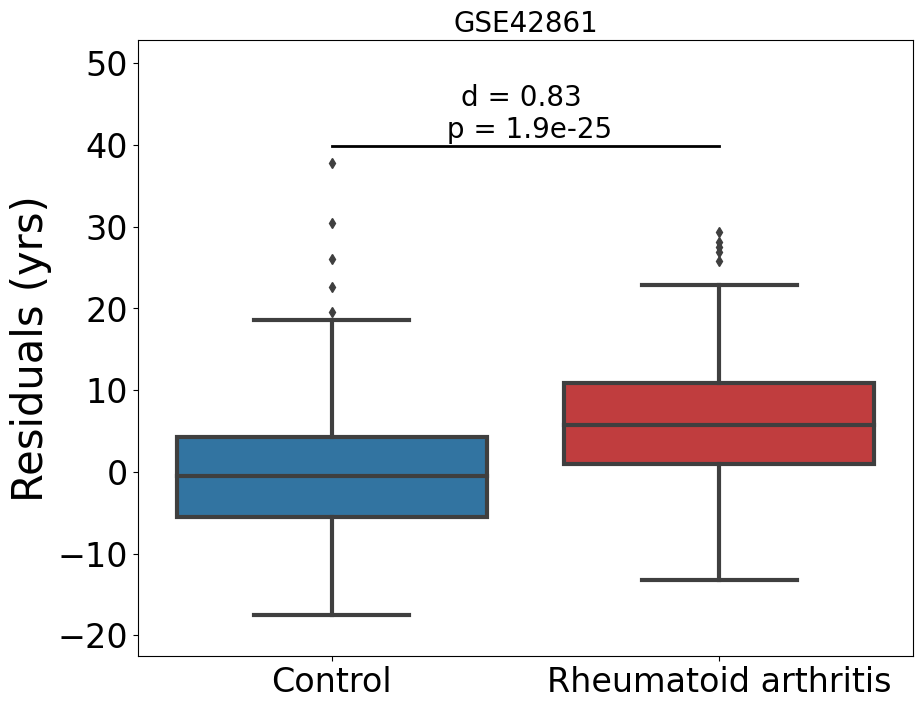

In [18]:
fig4_plots(art, art_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"Rheumatoid arthritis", flag=False)

# Generate Figure 4d-f (left)

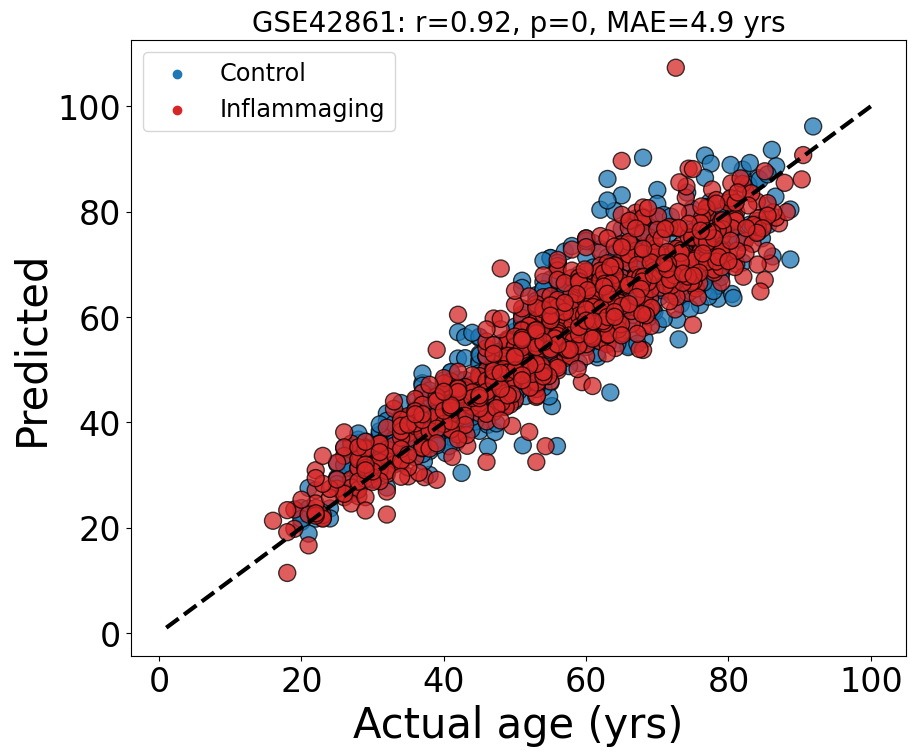

In [24]:
import joblib
age_corr_mfss_model = joblib.load('../../models/age_corr_mfss_model.joblib')
age_corr_mfss_selection = list(age_corr_mfss_model.feature_names_in_)
fig3_plots(no_dep,no_dep_meta,age_corr_mfss_model, age_corr_mfss_selection, "Inflammaging", flag=False)

# Generate Figure 4d-f (right)

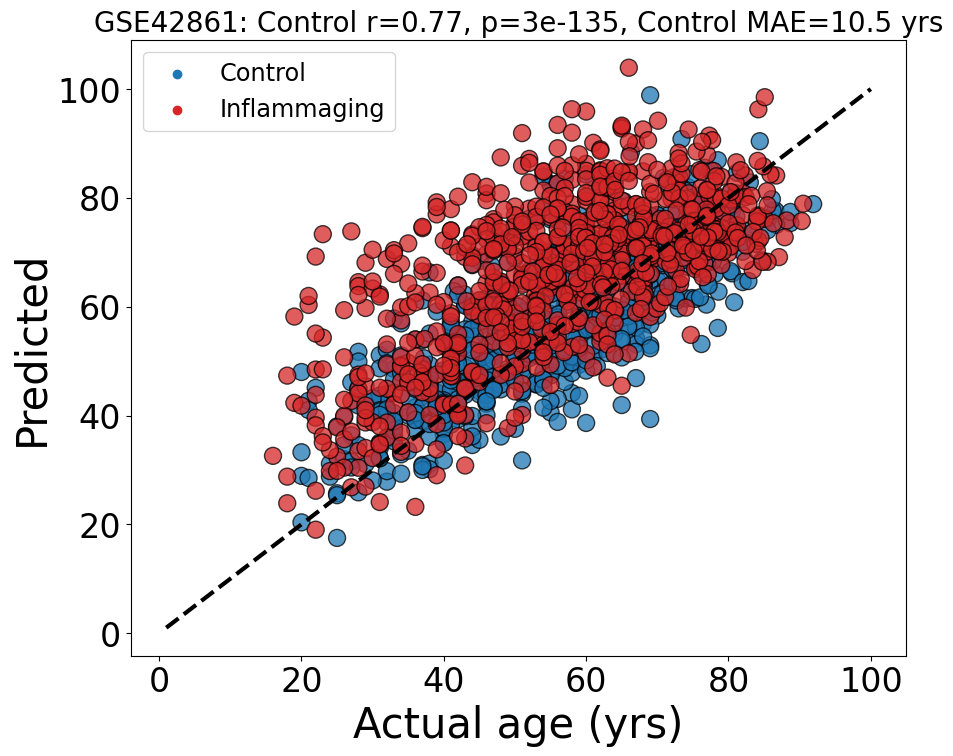

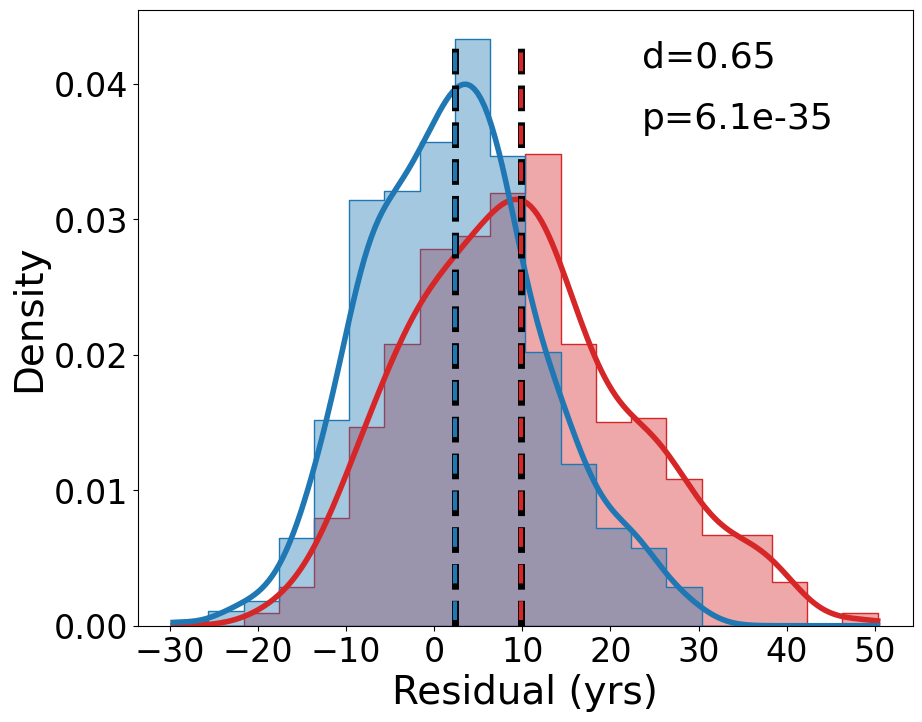

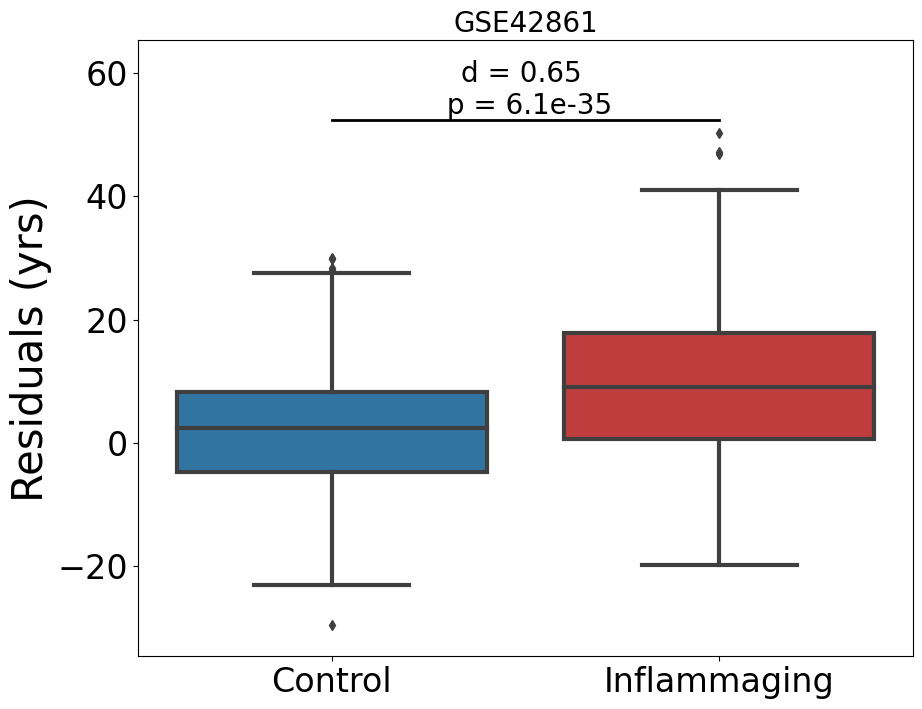

In [45]:
fig4_plots(no_dep, no_dep_meta,ir_shift_mfss_model,
           ir_shift_mfss_selection,d_shift,"Inflammaging", flag=False)

# Generate Supplementary Figure 6b (plus scatterplot & KDE plot)

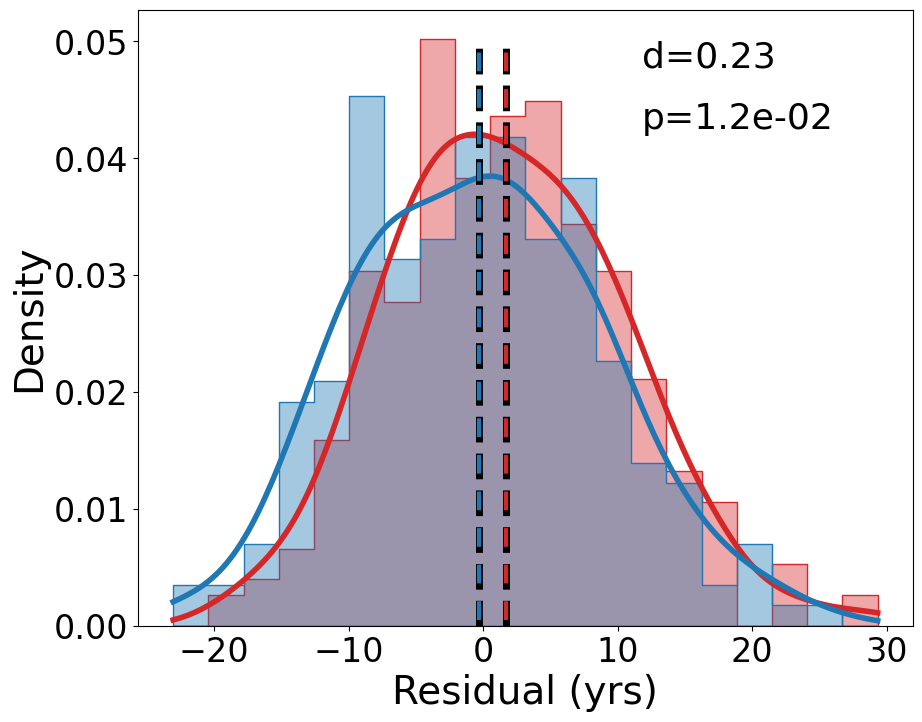

In [30]:
fig4_plots(park, park_meta,ir_shift_mfss_model,
           ir_shift_mfss_selection,d_shift,"Parkinson's disease", flag=False)

# Generate Supplementary Figure 6c (plus scatterplot & KDE plot)

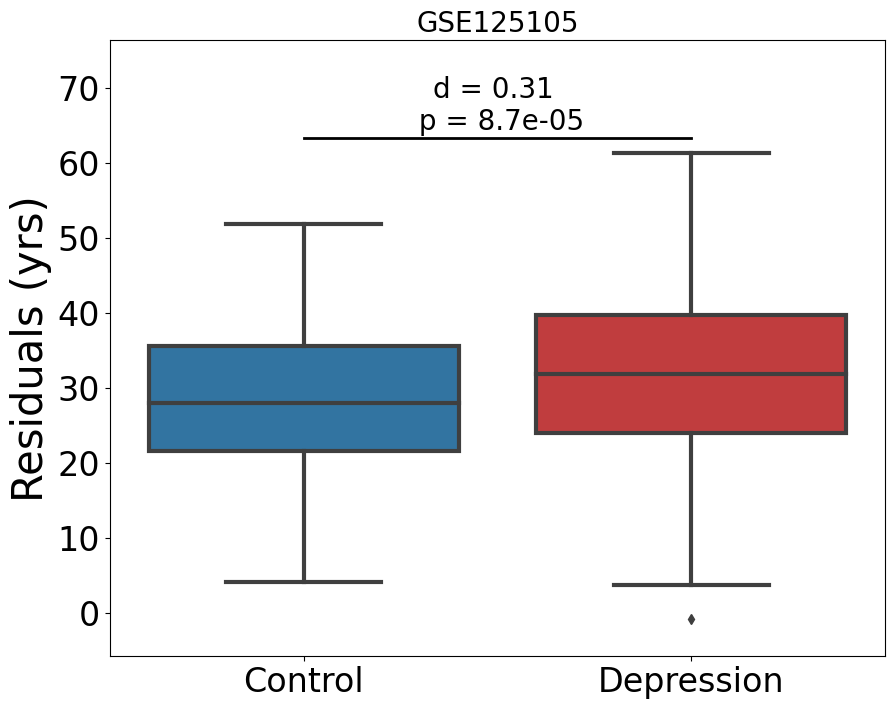

In [34]:
fig4_plots(dep, dep_meta,ir_shift_mfss_model,
           ir_shift_mfss_selection,d_shift,"Depression", flag=False)

# Generate Supplementary Figure 6d (plus scatterplot & KDE plot)

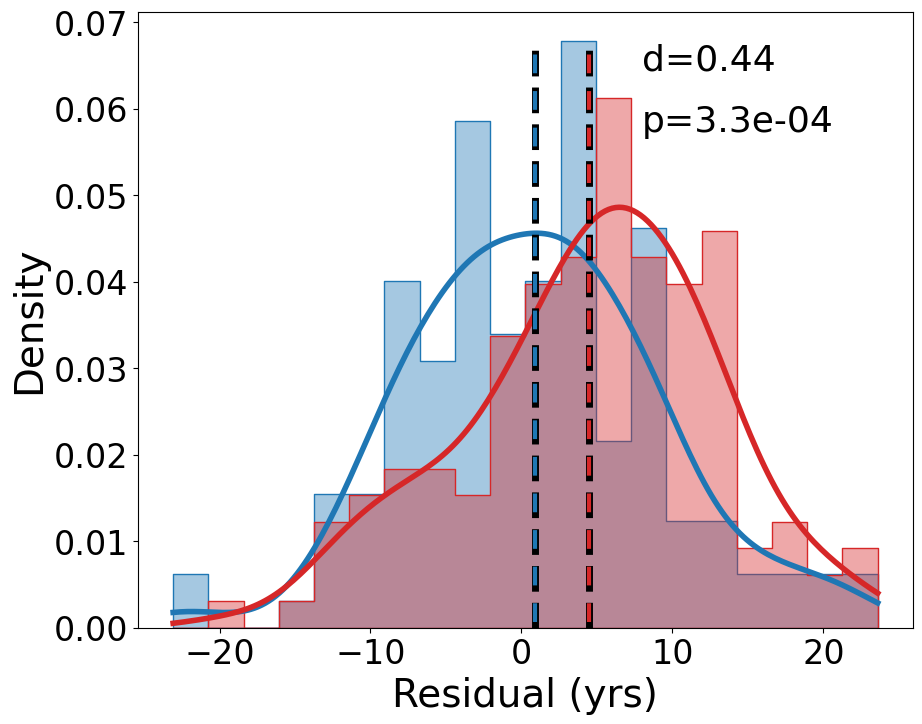

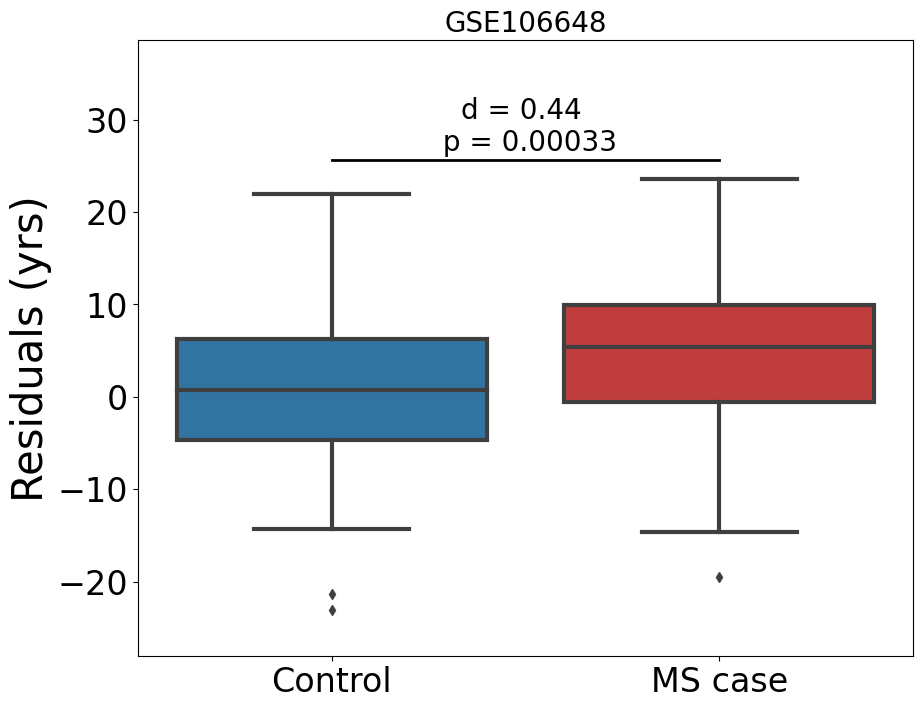

In [36]:
fig4_plots(ms, ms_meta,ir_shift_mfss_model,
           ir_shift_mfss_selection,d_shift,"MS case", flag=False)

# Generate Supplementary Figure 6e (plus scatterplot & KDE plot)

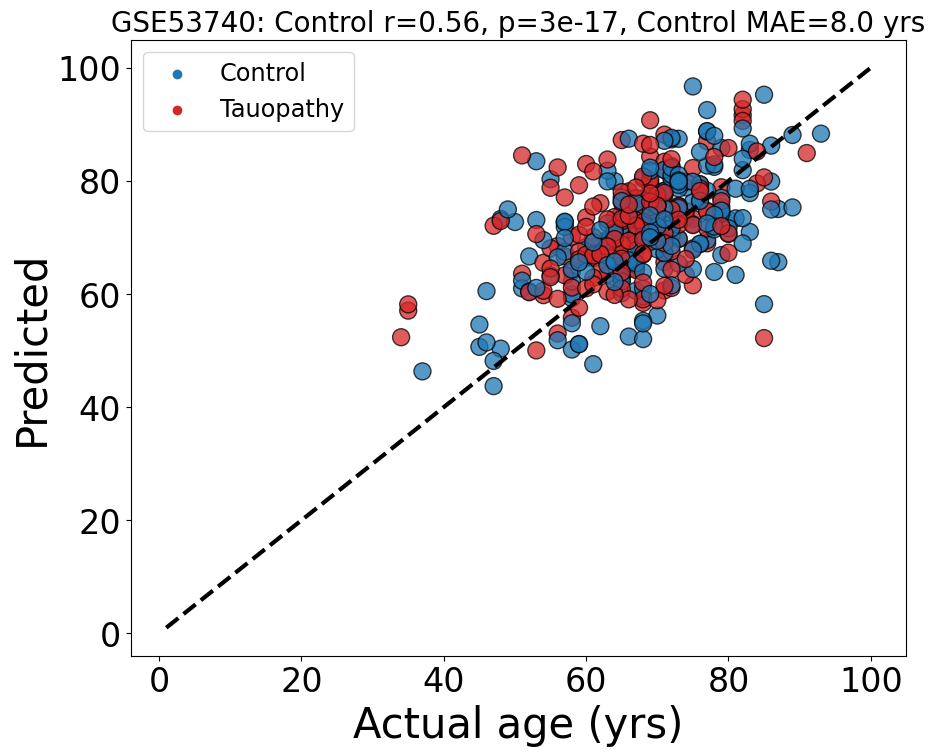

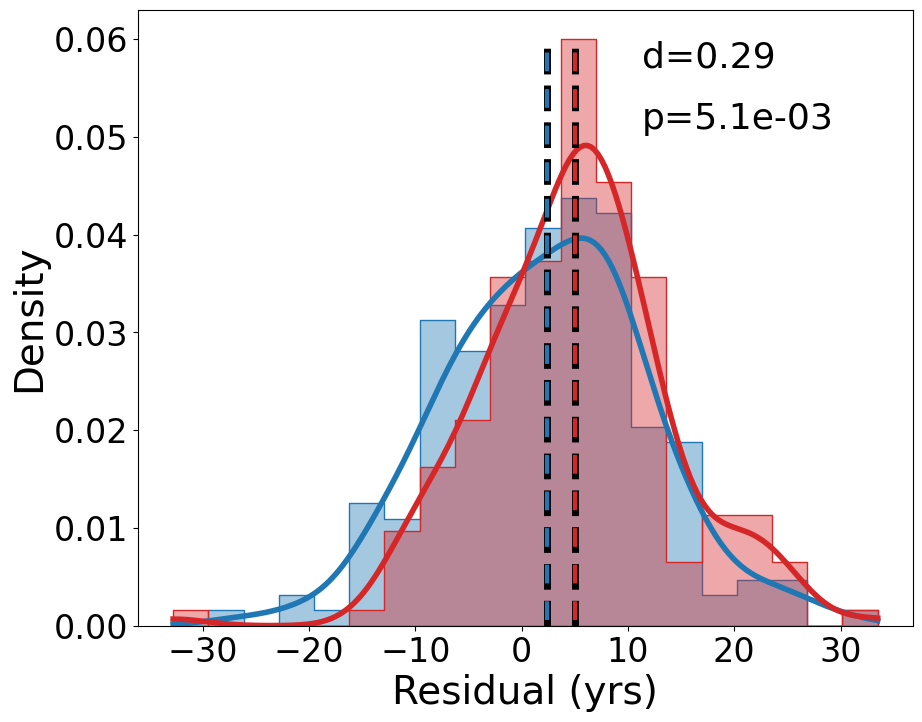

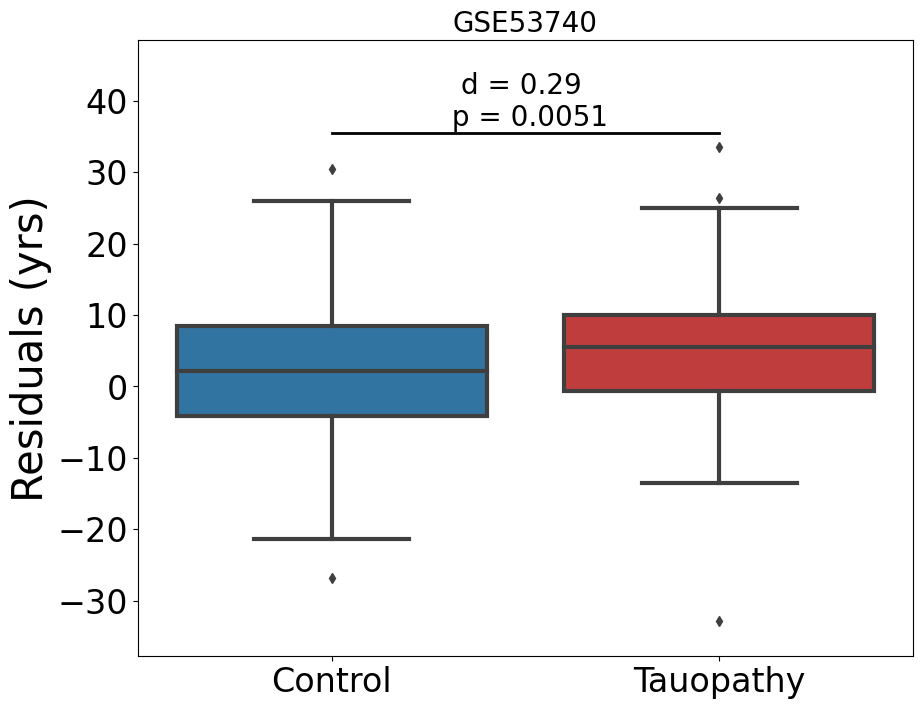

In [38]:
fig4_plots(tau, tau_meta, ir_shift_mfss_model,
           ir_shift_mfss_selection,d_shift,"Tauopathy", flag=True)

# Generate Supplementary Figure 6f (plus scatterplot & KDE plot)

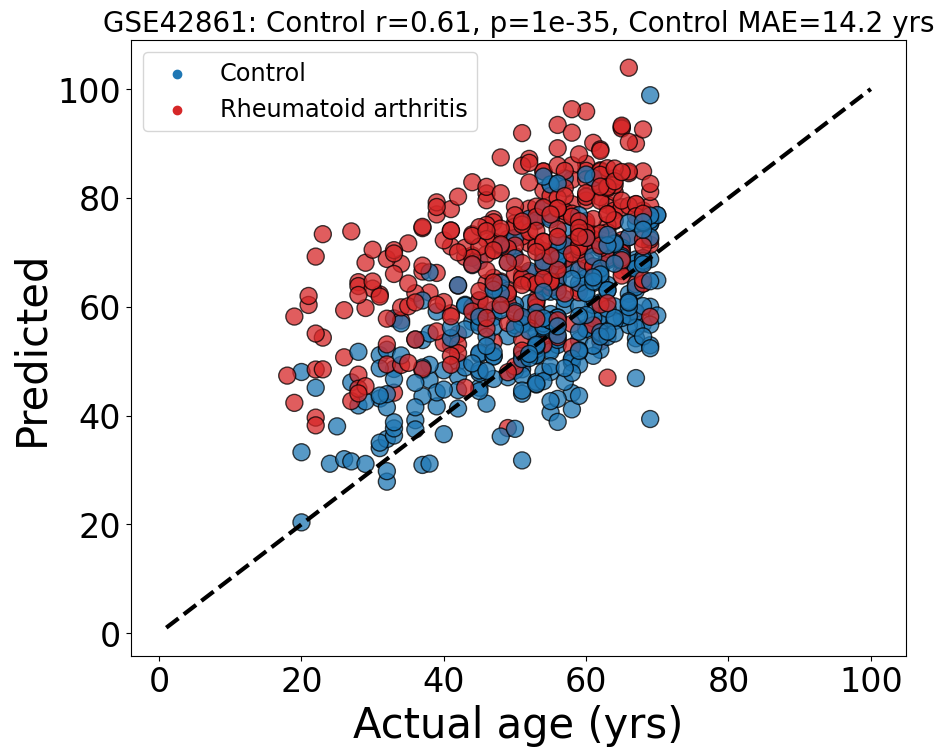

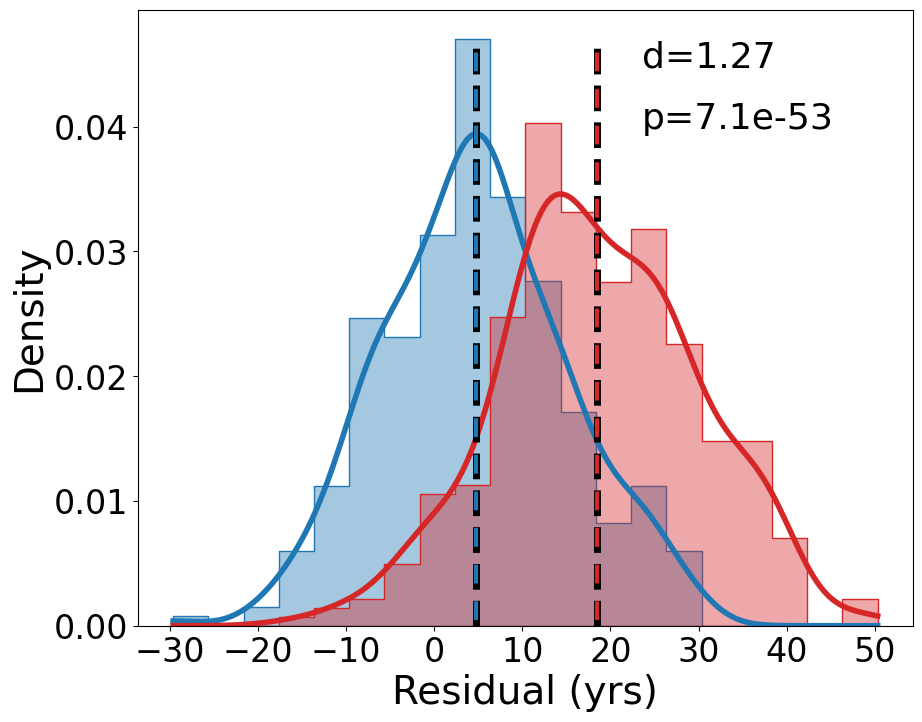

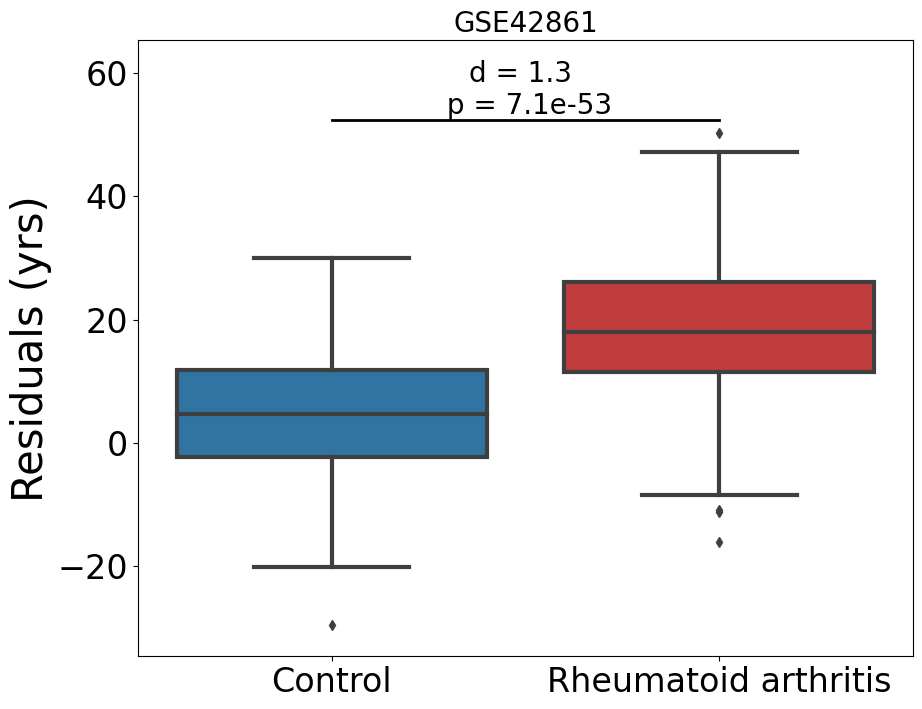

In [40]:
fig4_plots(art, art_meta, ir_shift_mfss_model,
           ir_shift_mfss_selection,d_shift,"Rheumatoid arthritis", flag=False)

### Load manifest and get the IR-mFSS model CpGs to get gene annotations

In [50]:
manifest = pd.read_csv(data_path + 'metadata/450K_manifest.csv', low_memory=False)

In [56]:
ir_model_cgs=model_df.Feature[:-1]

# Generate Supplementary Table 7 (main functions were added manually)

In [58]:
# Used from the genes_from_cgs.py script
get_gene_annotations(manifest, ir_model_cgs)

Probes        Gene
0               cg00161515      PRDM16
1               cg00573770        SELP
2               cg01820962      HIVEP3
3               cg03335938       UBE2F
4               cg03366574        ZEB2
5               cg03646329        DGKG
6               cg04135377      MIR874
7               cg04135377       KLHL3
8               cg04986004      SH3RF2
9               cg05507459      RNF180
10              cg05696969      NT5DC1
11              cg06419846     SYNGAP1
12              cg06896988      STXBP5
13              cg07192048     SNRNP48
14              cg09790134       INHBA
15              cg09790134   LOC285954
16              cg10144493        RPA3
17              cg11067179       NXNL2
18              cg11847992       PARD3
19  cg13001142, cg14614643       CD248
20              cg14076258      SHANK2
21              cg15167547        PAK1
22              cg15903032  SLC22A18AS
23              cg15903032    SLC22A18
24              cg17802213      CHST11
25              cg19307545        LAG3
26              cg21139312      ATF7IP
27              cg22914338         RB1
28              cg22914338       LPAR6
29              cg23126342       PCDH9
30              cg23167606    CDC42BPB
31              cg23744638        CA5A
32              cg23922560      FAM86A
33              cg26665035        MSI2
34         ch.7.143447326F       CECR2